# Homework 1

## Imitation learning & DAgger

### Warmup

The starter code provides an expert policy for each of the MuJoCo tasks in OpenAI gym (See `run_expert.py`). Generate roll-outs from the provided policies, and implement behavioral cloning. Run behavioral cloning (BC) on the Hopper-v1 environment, and report a learning curve plotting the loss function for the behavior cloning objective versus number of learning iterations. Your plot should show the (training) loss as a function of the number of gradient steps, and the loss should be improving over time. However, there is no other requirement for the warmup – you do not have to report any measure of final performance, just demonstrate that the network is training and the loss is improving

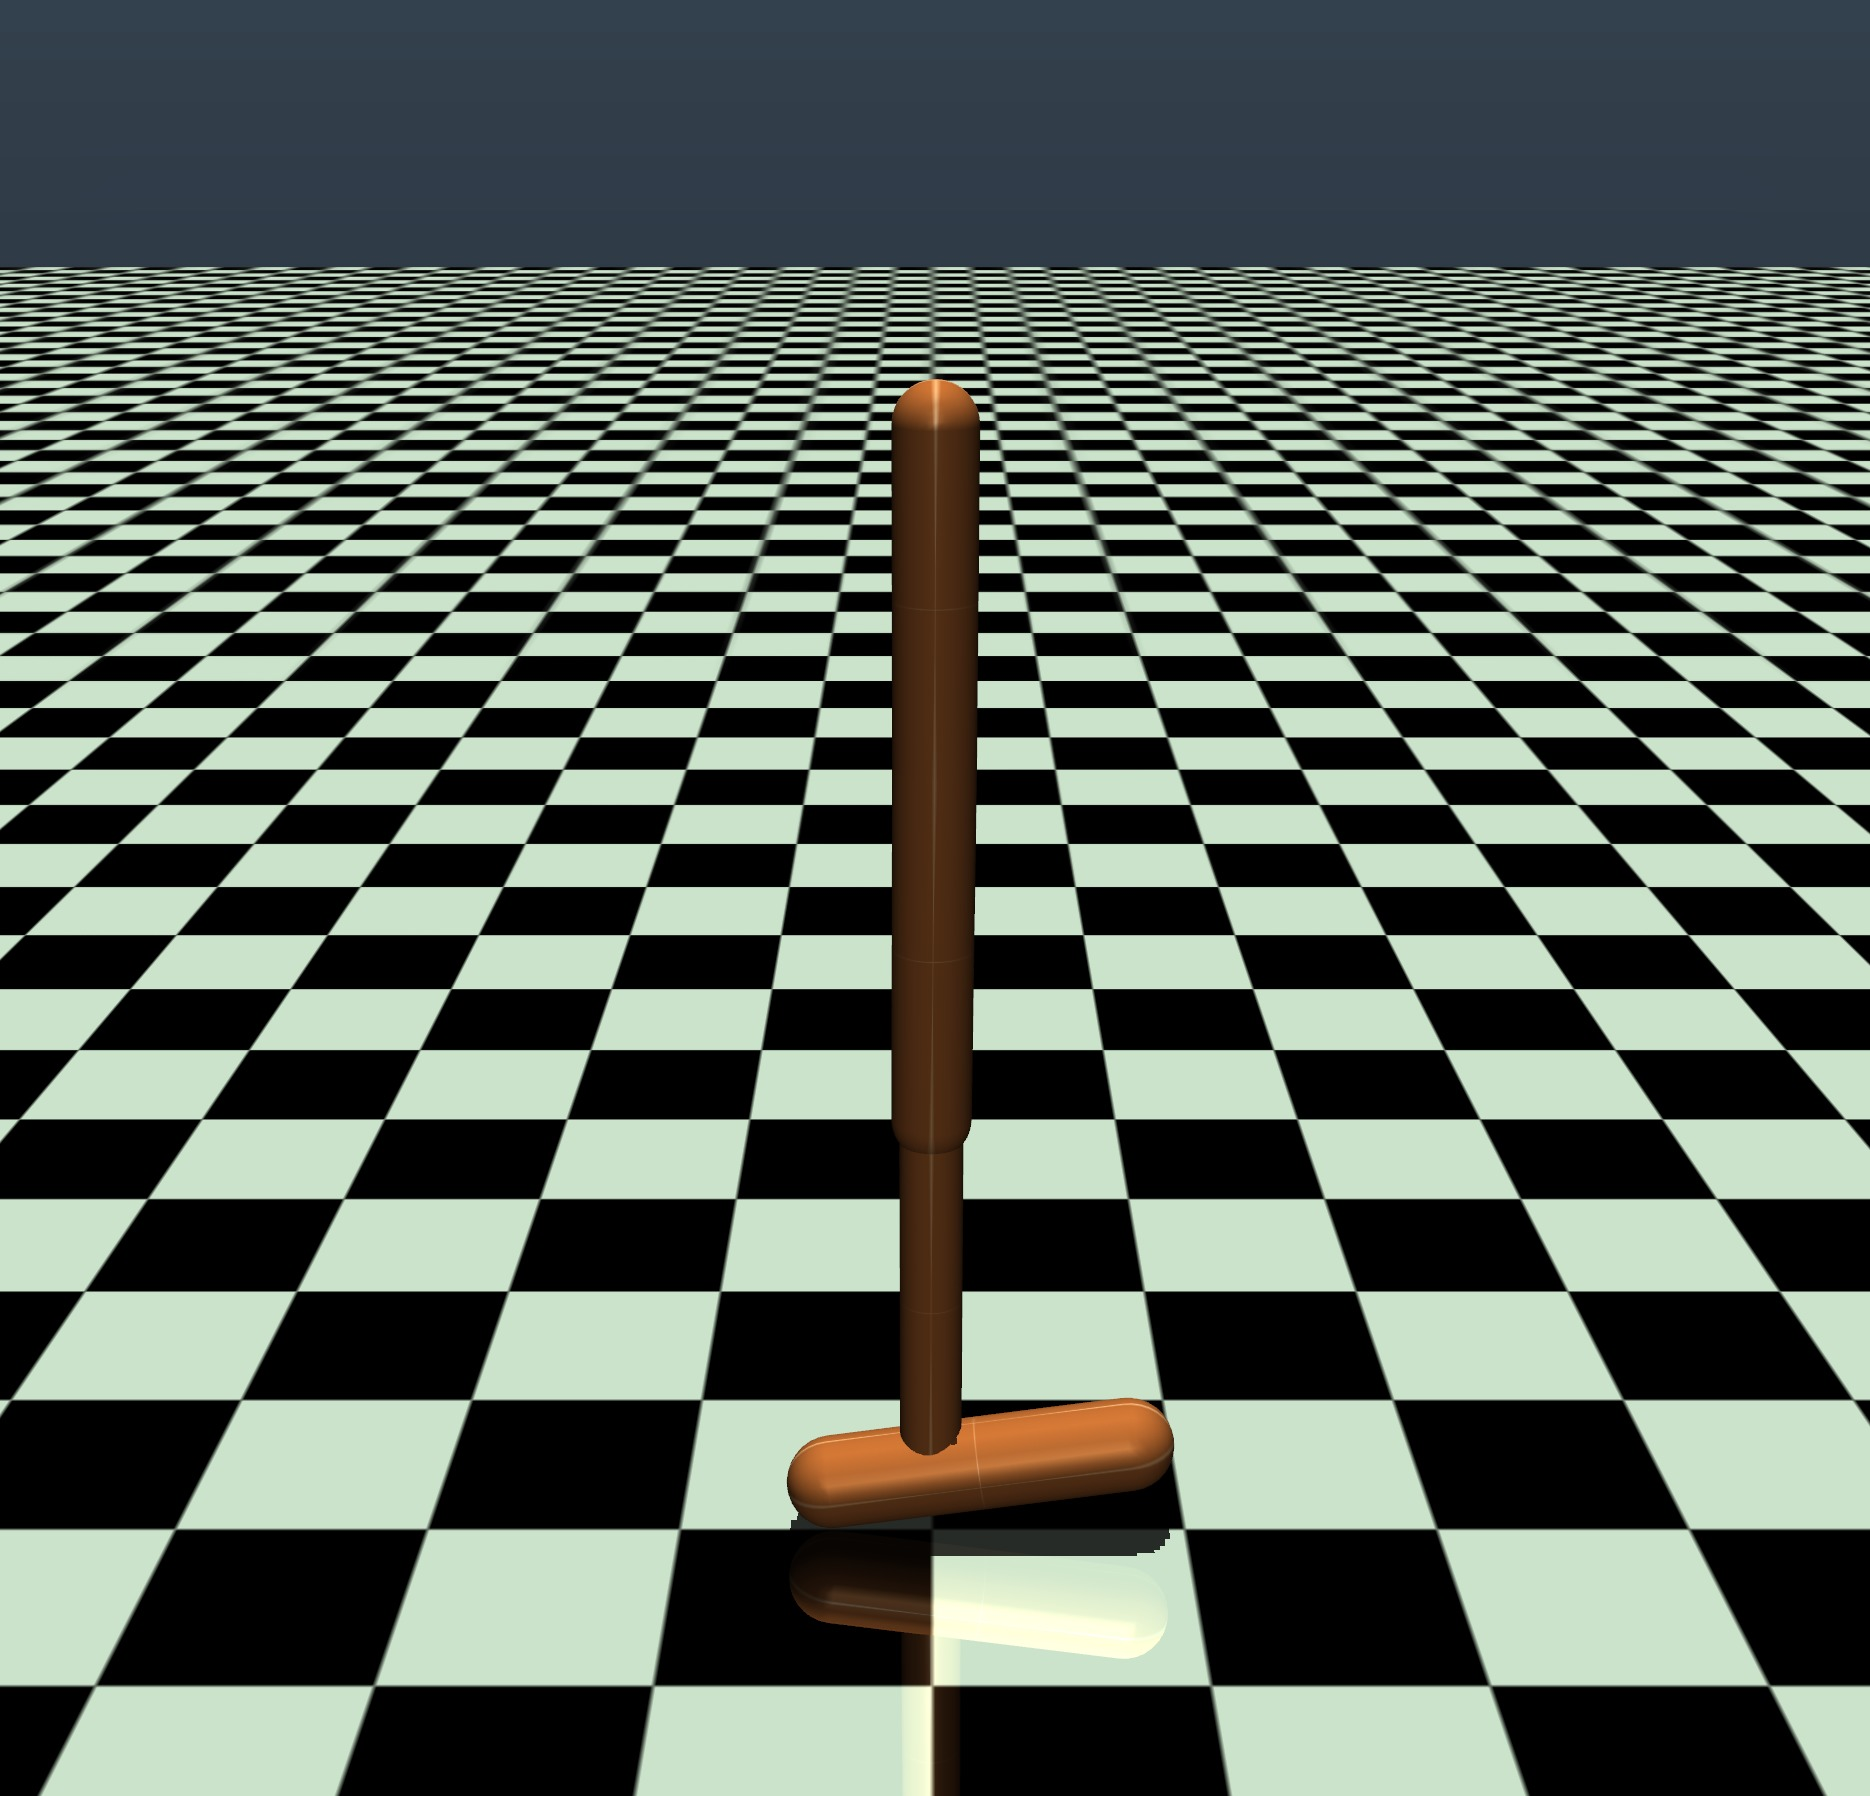


In [1]:
"""
I generate the training database using the code from `run_expert.py`
"""

import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy

def GenerateWarmupData(num_rollouts):
    """
    Generates a database of expert observation-action pair of size `num_rollouts` 
    """

    print('loading and building expert policy')
    policy_fn = load_policy.load_policy('experts/Hopper-v1.pkl')
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()
        # it is cool thing to note that not every library is imported at the beginning
        # Especially useful when loading multiple large libraries
        import gym
        env = gym.make('Hopper-v1')
        max_steps = env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(num_rollouts):
            print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            returns.append(totalr)
        
        print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))
        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions).squeeze()}
    return expert_data

/home/botoscs/.virtualenvs/all/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
expert_data = GenerateWarmupData(20)

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2018-04-08 07:38:02,310] From /home/botoscs/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2018-04-08 07:38:02,325] From /home/botoscs/.virtualenvs/all/lib/python3.5/site-packages/tensorflow/python/util/tf_should_use.py:118: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2018-04-08 07:38:02,329] Making new env: Hopper-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
returns [3776.8464365176064, 3775.9058036589836, 3779.4363219248703, 3783.540400656191, 3778.327071196469, 3776.4145760750525, 3775.416059263991, 3776.2397494074708, 3780.526323780493, 3783.5925459097284, 3776.4814277178984, 3776.421207672983, 3774.989937408346, 3786.1974138584133, 3779.716200200042, 3776.9472536558874, 3775.2877180258865, 3782.059652439981, 3780.6277476182795, 3776.6152910969745]
mean return 3778.5794569042773
std of return 3.158993056275956


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 10

(62212, 376)


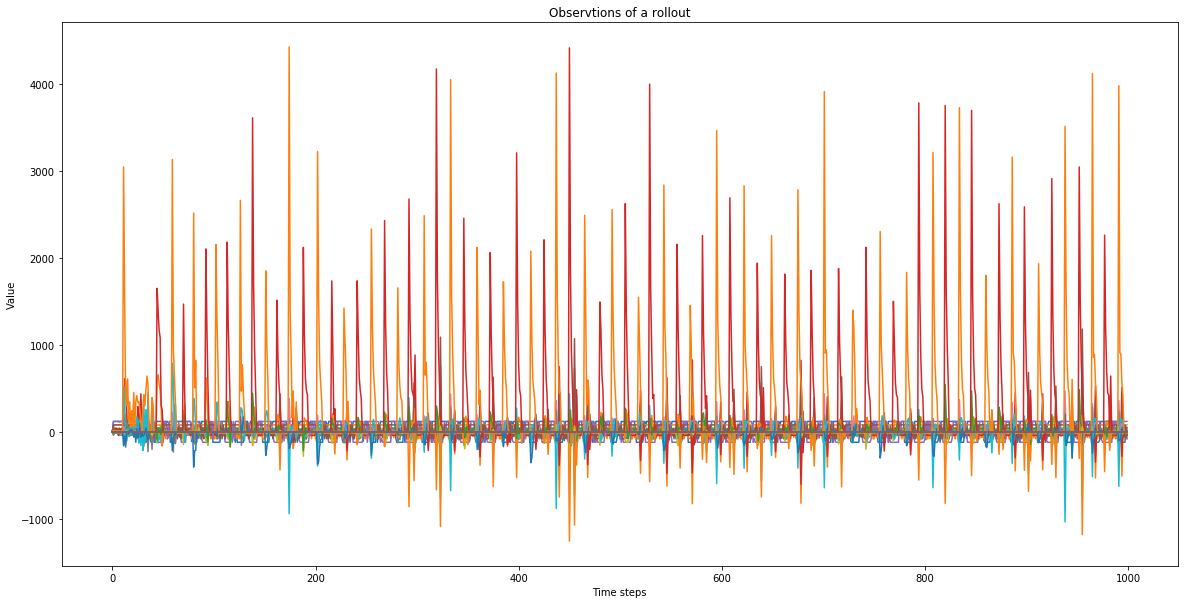

(62212, 17)


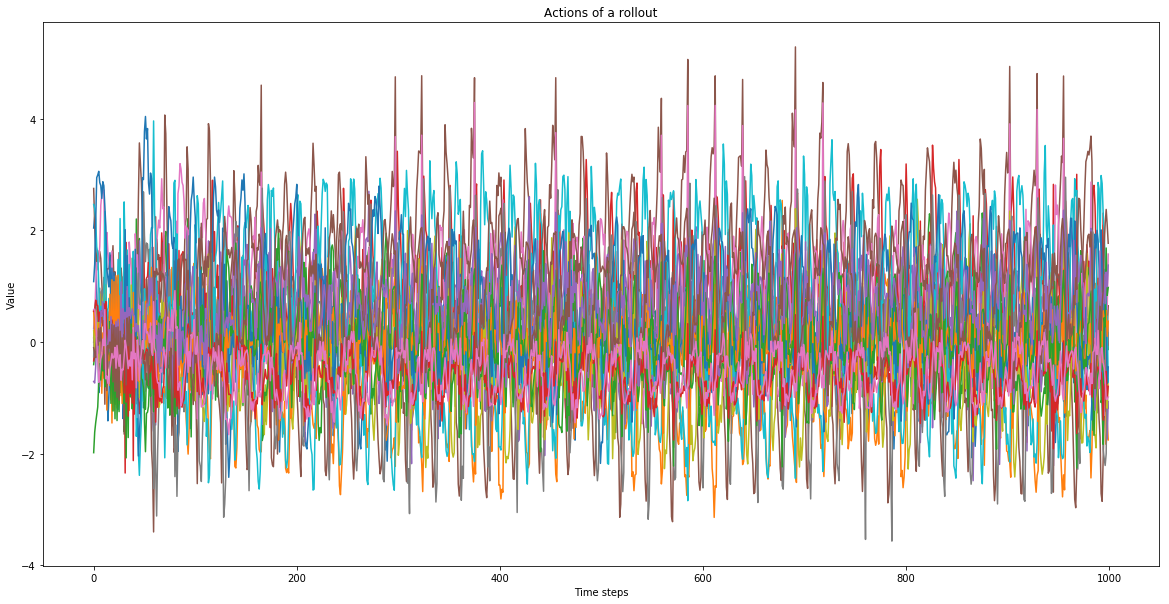

In [37]:
print(expert_data['observations'].shape)
plt.plot(expert_data['observations'][:1000])
plt.title('Observtions of a rollout')
plt.ylabel('Value')
plt.xlabel('Time steps')
plt.show()


print(expert_data['actions'].shape)
plt.plot(expert_data['actions'][:1000])
plt.title('Actions of a rollout')
plt.ylabel('Value')
plt.xlabel('Time steps')
plt.show()

In [5]:
"""
Now I just do the good-ol supervised learning
"""
import torch
from torch.nn import Linear, ReLU

def getMLP(input_dim, output_dim, hidden_dims):    
    """
    A vanilla MLP generator, with ReLU hidden, and Linear output layer
    """
    # Initial layers
    layers = [
        Linear(input_dim, hidden_dims[0]),
        ReLU()
    ]
    
    # Hidden layers
    prev_dim = hidden_dims[0]
    for h_dim in hidden_dims[1:]:
        layers.append(Linear(prev_dim, h_dim))
        layers.append(ReLU())
        prev_dim = h_dim
                   
    # Output layer
    layers.append(Linear(hidden_dims[-1], output_dim, bias=False))
    
    MLP = torch.nn.Sequential(*layers)
    return MLP

In [6]:
"""
Defining the policy network
"""
input_dim = expert_data['observations'].shape[-1]
output_dim = expert_data['actions'].shape[-1]
hidden_dims = [64]

policy_net = getMLP(input_dim, output_dim, hidden_dims)
print(policy_net)

Sequential(
  (0): Linear(in_features=11, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=3)
)


In [7]:
"""
Training the policy network
"""
from torch.autograd import Variable
from torch import FloatTensor

X = Variable(FloatTensor(expert_data['observations']))
Y = Variable(FloatTensor(expert_data['actions']))
if torch.cuda.is_available():
    X = X.cuda()
    Y = Y.cuda()
    policy_net.cuda()
    
loss = torch.nn.MSELoss()
opt = torch.optim.Adam(policy_net.parameters())
losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    if epoch % 10 == 0: print('Epoch:', epoch)
    opt.zero_grad()
    actions = policy_net(X)
    L2 = loss(actions, Y)
    L2.backward()
    opt.step()
    losses.append(L2.cpu().data.numpy())

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150
Epoch: 160
Epoch: 170
Epoch: 180
Epoch: 190
Epoch: 200
Epoch: 210
Epoch: 220
Epoch: 230
Epoch: 240
Epoch: 250
Epoch: 260
Epoch: 270
Epoch: 280
Epoch: 290
Epoch: 300
Epoch: 310
Epoch: 320
Epoch: 330
Epoch: 340
Epoch: 350
Epoch: 360
Epoch: 370
Epoch: 380
Epoch: 390
Epoch: 400
Epoch: 410
Epoch: 420
Epoch: 430
Epoch: 440
Epoch: 450
Epoch: 460
Epoch: 470
Epoch: 480
Epoch: 490
Epoch: 500
Epoch: 510
Epoch: 520
Epoch: 530
Epoch: 540
Epoch: 550
Epoch: 560
Epoch: 570
Epoch: 580
Epoch: 590
Epoch: 600
Epoch: 610
Epoch: 620
Epoch: 630
Epoch: 640
Epoch: 650
Epoch: 660
Epoch: 670
Epoch: 680
Epoch: 690
Epoch: 700
Epoch: 710
Epoch: 720
Epoch: 730
Epoch: 740
Epoch: 750
Epoch: 760
Epoch: 770
Epoch: 780
Epoch: 790
Epoch: 800
Epoch: 810
Epoch: 820
Epoch: 830
Epoch: 840
Epoch: 850
Epoch: 860
Epoch: 870
Epoch: 880
Epoch: 890
Epoch: 900
Epoch: 910

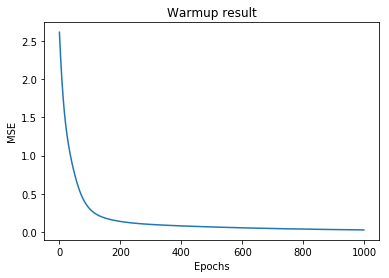

In [8]:
plt.plot(losses)
plt.title('Warmup result')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

## Testing the trained Hopper agent

In [9]:
def policy_wrapper(policy_net):
    def wrapped_policy_net(obs):
        X = Variable(FloatTensor(obs))
        if torch.cuda.is_available():
            X = X.cuda()

        return policy_net(X).cpu().data.numpy()
    return wrapped_policy_net

In [23]:
def TestAgent(policy_fn, env_name='Hopper', render=False, num_rollouts=3, show_after_done=False):
    returns = []
    observations = []
    actions = []
    env = gym.make(env_name+'-v1')
    for i in range(num_rollouts):
        print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done or show_after_done:
            action = policy_fn(obs[None,:])
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            observations.append(obs)
            actions.append(action)
            if render:
                env.render()
            #if steps % 100 == 0: print("%i/%i"%(steps, env.spec.timestep_limit))
            if steps >= env.spec.timestep_limit:
                break
        returns.append(totalr)

    if render:
        env.render(close=True)
    
    print('returns', returns)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))
    agent_data = {'observations': np.array(observations),
                  'actions': np.array(actions)}
    return agent_data, returns

In [11]:
policy_fn = policy_wrapper(policy_net)
agent_data, returns = TestAgent(policy_fn, 'Hopper', True)

[2018-04-08 07:38:20,375] Making new env: Hopper-v1


iter 0
iter 1
iter 2
returns [222.74614440089482, 221.45544166062393, 877.5282300631584]
mean return 440.5766053748924
std of return 308.97190618423264


#  Behavioral Cloning


1. Run  behavioral  cloning  (BC)  and  report  results  on  two  other  tasks  –  one  task  where  a  behavioral cloning agent achieves comparable performance to the expert, and one task where it does not.  Whenproviding  results,  report  the  mean  and  standard  deviation  of  the  return  over  multiple  rollouts  in  atable, and state which task was used.  Be sure to set up a fair comparison, in terms of network size,amount of data, and number of training iterations, and provide these details (and any others you feel are appropriate) in the table caption

In [12]:
def GenerateExpertData(env_name, num_rollouts=20, render=True):
    """
    Generates a database of expert observation-action pair of size `num_rollouts` 
    """

    print('loading and building expert policy')
    policy_fn = load_policy.load_policy('experts/%s-v1.pkl'%env_name)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()
        env = gym.make(env_name+'-v1')
        max_steps = env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(num_rollouts):
            print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                if render:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            returns.append(totalr)
        
        if render:
            env.render(close=True)

        print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))
        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions).squeeze()}
    return expert_data

In [13]:
def VisualizeAgentData(agent_data, rollout_length=1000):
    print(agent_data['observations'].shape)
    plt.plot(agent_data['observations'][:rollout_length])
    plt.title('Observtions of a rollout')
    plt.ylabel('Value')
    plt.xlabel('Time steps')
    plt.show()


    print(agent_data['actions'].shape)
    plt.plot(agent_data['actions'][:rollout_length])
    plt.title('Actions of a rollout')
    plt.ylabel('Value')
    plt.xlabel('Time steps')
    plt.show()

In [14]:
def BCAgent(expert_data, hidden_dims=[64], num_epochs=1000, 
            loss=torch.nn.MSELoss(), pretrained_agent=None):
    # Define agent
    input_dim = expert_data['observations'].shape[-1]
    output_dim = expert_data['actions'].shape[-1]
    if pretrained_agent:
        policy_net = pretrained_agent
    else:        
        policy_net = getMLP(input_dim, output_dim, hidden_dims)
    
    print('Agent\'s Policy function:\n', policy_net)
    
    X = Variable(FloatTensor(expert_data['observations']))
    Y = Variable(FloatTensor(expert_data['actions']))
    if torch.cuda.is_available():
        X = X.cuda()
        Y = Y.cuda()
        policy_net.cuda()
    opt = torch.optim.Adam(policy_net.parameters())
    losses = []
    for epoch in range(num_epochs):
        if epoch % (num_epochs//10) == 0: print('Epoch:', epoch)
        opt.zero_grad()
        actions = policy_net(X)
        L2 = loss(actions, Y)
        L2.backward()
        opt.step()
        losses.append(L2.cpu().data.numpy())

    print('Behaviour cloning finished')
    plt.plot(losses)
    plt.title('BC result')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.show()
    
    return policy_net

## Testing Ant

In [15]:
ant_expert_data = GenerateExpertData('Ant', num_rollouts=20, render=False)

[2018-04-08 07:38:28,615] Making new env: Ant-v1


loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
returns [4876.764138709939, 4824.489987778331, 4924.62549734514, 4780.23633775423, 4645.914035903804, 4770.5211071873555, 4734.0797574714215, 4780.4833653318, 4823.567801595188, 4533.517909280093, 4831.8793531346255, 4847.494292879876, 4837.719192807699, 4578.9765093848155, 4848.584681638488, 4757.572022643378, 4942.5472158904995, 4768.6536526472955, 5135.211873364995, 4768.430235012186]
mean return 4800.5634483880585
std of return 125.63577348432317


Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


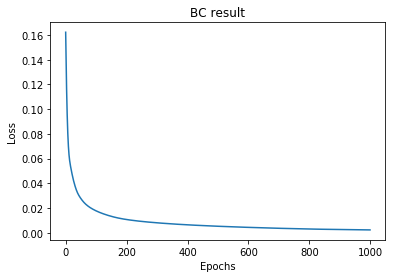

In [16]:
ant_policy_network = BCAgent(ant_expert_data, num_epochs=1000)

In [17]:
ant_policy_fn = policy_wrapper(ant_policy_network)
ant_agent_data, ant_returns = TestAgent(ant_policy_fn, env_name='Ant', render=True, num_rollouts=10)

[2018-04-08 07:38:57,851] Making new env: Ant-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [3901.2183672298574, 5044.235710095866, 4602.0631147839, 4716.60113804753, 4665.797938904645, 4735.473151894692, 4685.802938349966, 4444.40479692007, 4710.4293221895705, 4908.334094349152]
mean return 4641.4360572765245
std of return 290.44632100757536


## Testing HalfCheetah

In [19]:
HC_expert_data = GenerateExpertData('HalfCheetah', num_rollouts=20, render=False)

[2018-04-08 07:39:42,701] Making new env: HalfCheetah-v1


loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
returns [4214.528171555222, 4200.655470055189, 4214.216267948161, 4059.2726840630817, 4198.156575381459, 4060.4901888841932, 4056.4747730076047, 4190.395719213971, 4171.020489783441, 3970.5204701357516, 4051.148957956897, 4133.949011463489, 4284.201789040388, 4052.4555046628275, 4157.767005800264, 4219.977553805104, 4293.4699897268265, 4186.5426312108375, 4109.276394093617, 4015.174552127271]
mean return 4141.984709995779
std of return 88.15652475521266


Agent's Policy function:
 Sequential(
  (0): Linear(in_features=17, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=6)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


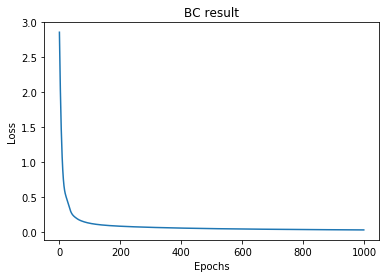

In [20]:
HC_policy_network = BCAgent(HC_expert_data, num_epochs=1000)

In [21]:
HC_policy_fn = policy_wrapper(HC_policy_network)
HC_agent_data, HC_returns = TestAgent(HC_policy_fn, env_name='HalfCheetah', render=True, num_rollouts=10)

[2018-04-08 07:40:05,034] Making new env: HalfCheetah-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [190.41353116917605, 131.38009032332351, 189.4467011420485, 232.55615739309653, 137.43962444403383, 166.3093106857007, 178.12056463340056, 142.74539257816258, 134.61799307496537, 159.54098094789757]
mean return 166.25703463918052
std of return 30.501463452798518


## Testing Humanoid

In [22]:
hum_expert_data = GenerateExpertData('Humanoid', num_rollouts=20, render=False)

[2018-04-08 07:40:33,208] Making new env: Humanoid-v1


loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
returns [10411.050436888952, 10251.869613501878, 10370.720535739689, 10372.189156613993, 10272.198853793709, 10491.422332110169, 10504.370900770753, 10386.611796486035, 10418.571159223666, 10458.736864073178, 10391.397816683422, 10413.75632781237, 10334.100464660936, 10357.813721130296, 10403.567889964866, 10382.918288078892, 10393.355906598568, 10349.846017240541, 10410.927839986098, 10354.556322094784]
mean return 10386.499112172638
std of return 59.59986461389529


Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


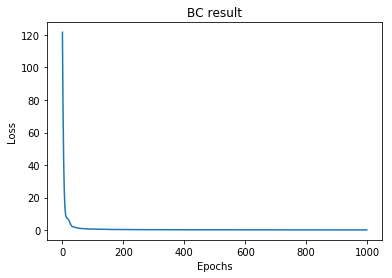

In [24]:
hum_policy_network = BCAgent(hum_expert_data, num_epochs=1000)

In [27]:
hum_policy_fn = policy_wrapper(hum_policy_network)
hum_agent_data, hum_returns = TestAgent(hum_policy_fn, env_name='Humanoid', 
                                        render=False, num_rollouts=10,
                                        show_after_done=False)

[2018-04-08 07:44:50,309] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [408.6871180034939, 797.0963040512412, 322.9837410268911, 609.4804342904094, 502.74436301608193, 473.56870621686744, 651.7425840689904, 607.7073762056481, 611.0067960308966, 699.4168074679534]
mean return 568.4434230378473
std of return 134.35116804683884


## Table 1

- Expert rollouts: 20
- Hidden: 64 (ReLU)
- Optimizer: Adam (1000 epoch)
- Results from 10 rollouts

Task | Rewards mean | Rewards std
--- | --- | ---
Hopper (expert) | **3779.34** | 3.73
Hopper (ours) | 145.29 | 0.61
Ant (expert) | 4608.11 | 788.98
Ant (ours) | **4724.66** | 133.33
HalfCheetah (expert) | **4156.78** | 90.93
HalfCheetah (ours) | 3012.47 | 219.77
Humanoid (expert) | **10415.85** | 33.61
Humanoid (ours) | 419.70 | 100.55

2. Experiment with one hyperparameter that affects the performance of the behavioral cloning agent, such as the number of demonstrations, the number of training epochs, the variance of the expert policy, or something that you come up with yourself.  For one of the tasks used in the previous question, show a graph of how the BC agent’s performance varies with the value of this hyperparameter, and state the hyperparameter and a brief rationale for why you chose it in the caption for the graph.

Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=8)
)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Behaviour cloning finished


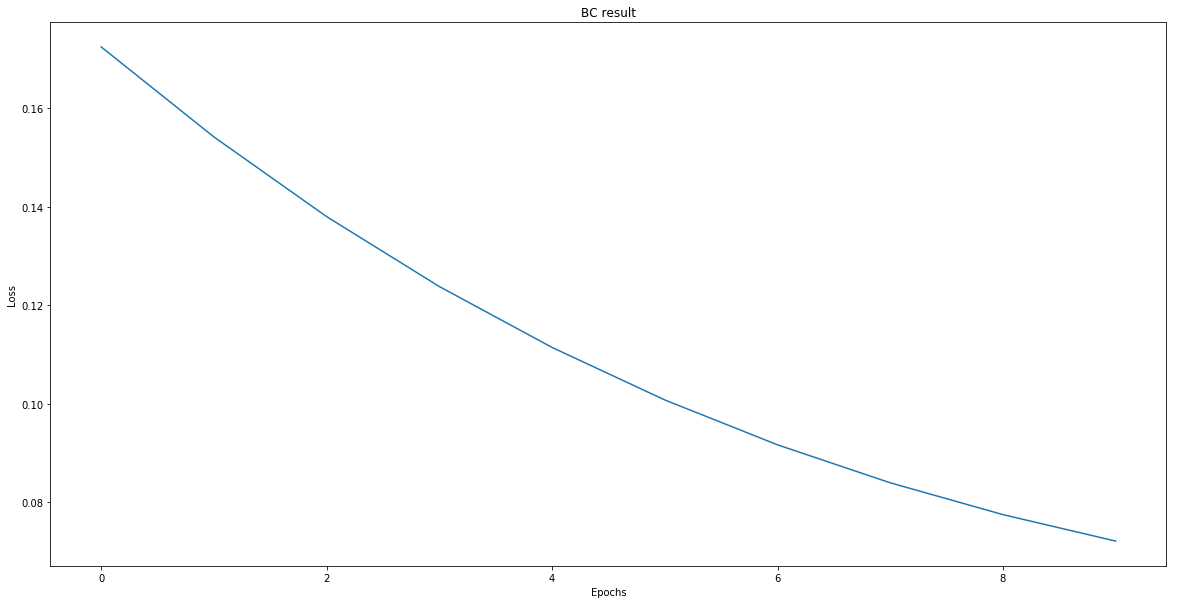

[2018-04-08 06:03:59,053] Making new env: Ant-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [964.1116783355161, 971.7592590038943, 968.1486810642767, 984.9103610515175, 956.7711540559371, 961.637335601348, 968.9799903225235, 991.4311580819193, 965.6702617858193, 977.6231010779368]
mean return 971.1042980380689
std of return 10.16586745715845
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=8)
)
Epoch: 0
Epoch: 5
Epoch: 10
Epoch: 15
Epoch: 20
Epoch: 25
Epoch: 30
Epoch: 35
Epoch: 40
Epoch: 45
Behaviour cloning finished


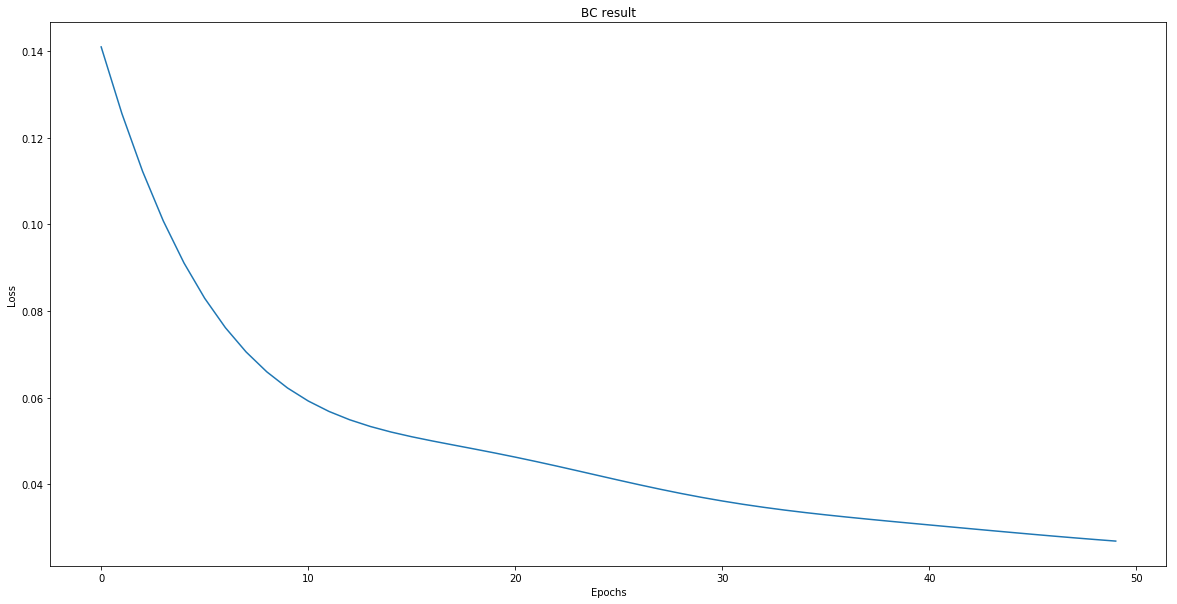

[2018-04-08 06:04:15,568] Making new env: Ant-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [1384.1934561329058, 1135.1465703889432, 1220.6538490881196, 1039.695797711057, 1155.700277410075, 1109.0322993237862, 1152.96291786993, 1229.2727504711556, 1166.9836020906378, 1213.3510072731976]
mean return 1180.6992527759808
std of return 86.66448399634805
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=8)
)
Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Behaviour cloning finished


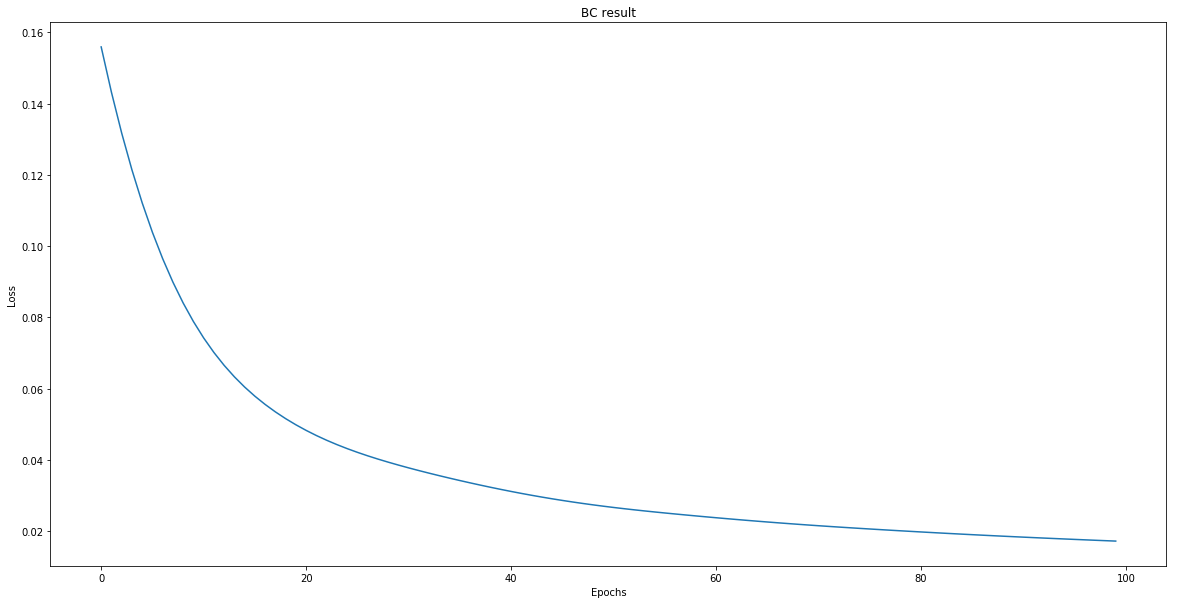

[2018-04-08 06:04:31,712] Making new env: Ant-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [859.0859448812652, 2046.1701411608778, 2920.3594776750456, 1697.2001437019499, 1136.2406617652507, 2801.9972693256373, 2649.99959720499, 92.59815844244915, 2818.1542685098925, 894.5196731815149]
mean return 1791.6325335848876
std of return 956.5469204184978
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=8)
)
Epoch: 0
Epoch: 25
Epoch: 50
Epoch: 75
Epoch: 100
Epoch: 125
Epoch: 150
Epoch: 175
Epoch: 200
Epoch: 225
Behaviour cloning finished


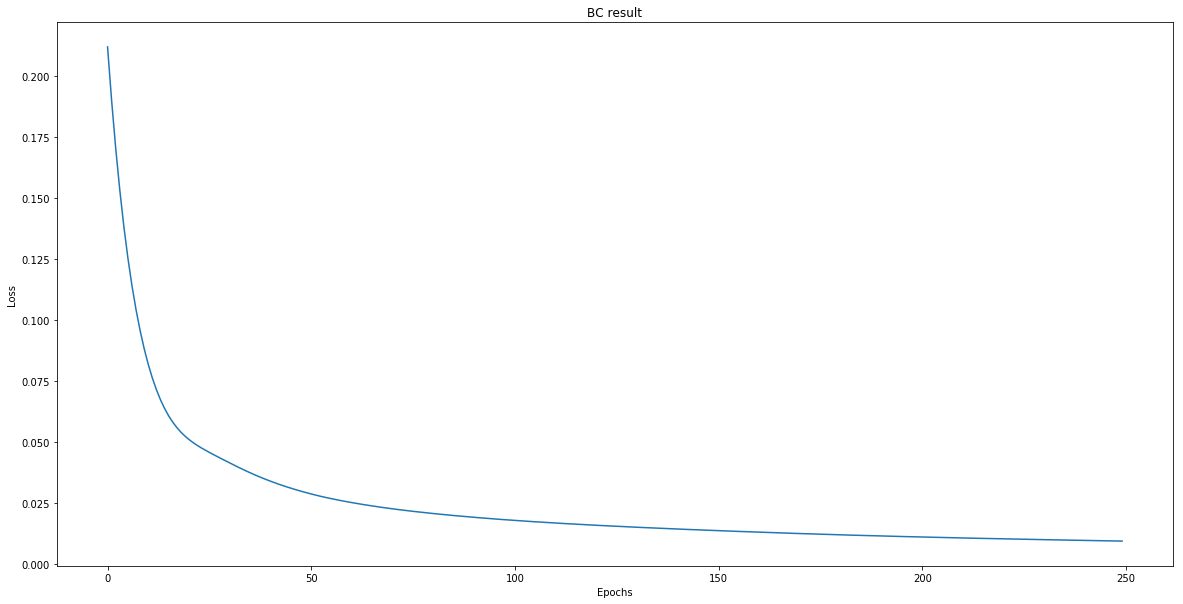

[2018-04-08 06:04:43,129] Making new env: Ant-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [1101.7907628881628, 936.5857127366093, 900.2697789612444, 1625.7401584937834, 1267.5776440765055, 817.2702170604074, 623.8530181086979, 856.93183044322, 948.9583875304453, 576.2801975047919]
mean return 965.5257707803867
std of return 292.07560817618696
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=8)
)
Epoch: 0
Epoch: 50
Epoch: 100
Epoch: 150
Epoch: 200
Epoch: 250
Epoch: 300
Epoch: 350
Epoch: 400
Epoch: 450
Behaviour cloning finished


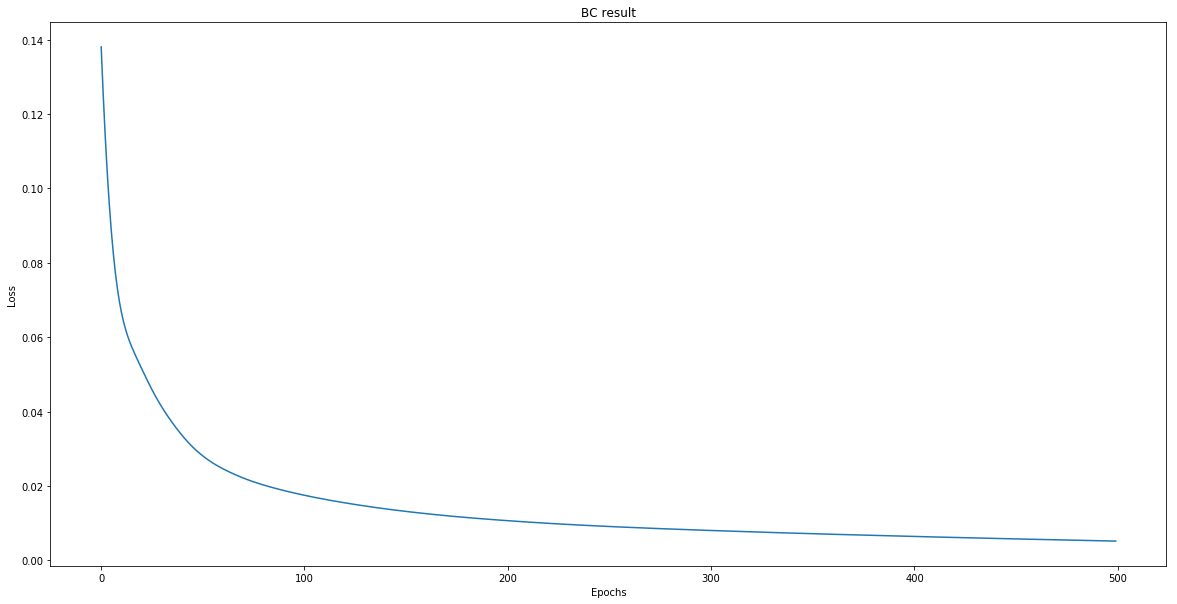

[2018-04-08 06:05:00,092] Making new env: Ant-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [4113.259278992744, 4056.678590170589, 4135.5353198300945, 3839.0375835376653, 373.3429480059009, 4084.584475000244, 3593.7843259154956, 1931.52100207605, 3959.033401659074, 3662.8548587165224]
mean return 3374.963178390438
std of return 1177.8100916108403
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=8)
)
Epoch: 0
Epoch: 75
Epoch: 150
Epoch: 225
Epoch: 300
Epoch: 375
Epoch: 450
Epoch: 525
Epoch: 600
Epoch: 675
Behaviour cloning finished


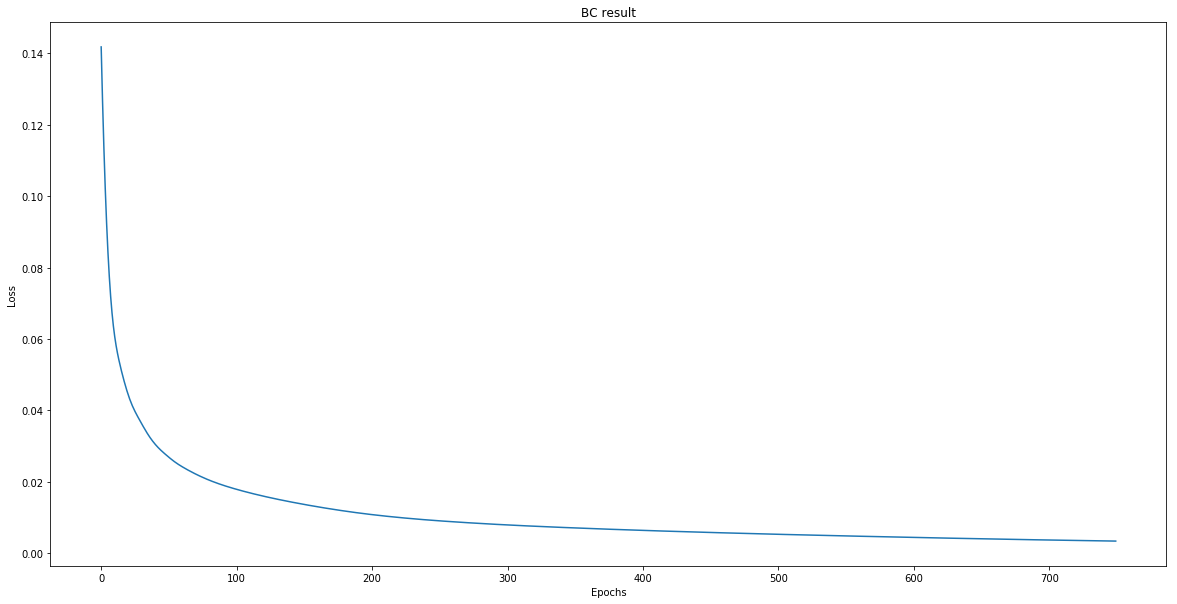

[2018-04-08 06:05:15,179] Making new env: Ant-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [4471.948576158923, 4575.29498827204, 4547.601287091928, 4608.17189850705, 4613.950566878372, 4444.407886615689, 4668.185491800148, 4439.5047498262975, 4430.404603574553, 4574.793129416463]
mean return 4537.426317814146
std of return 80.54486219875672
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


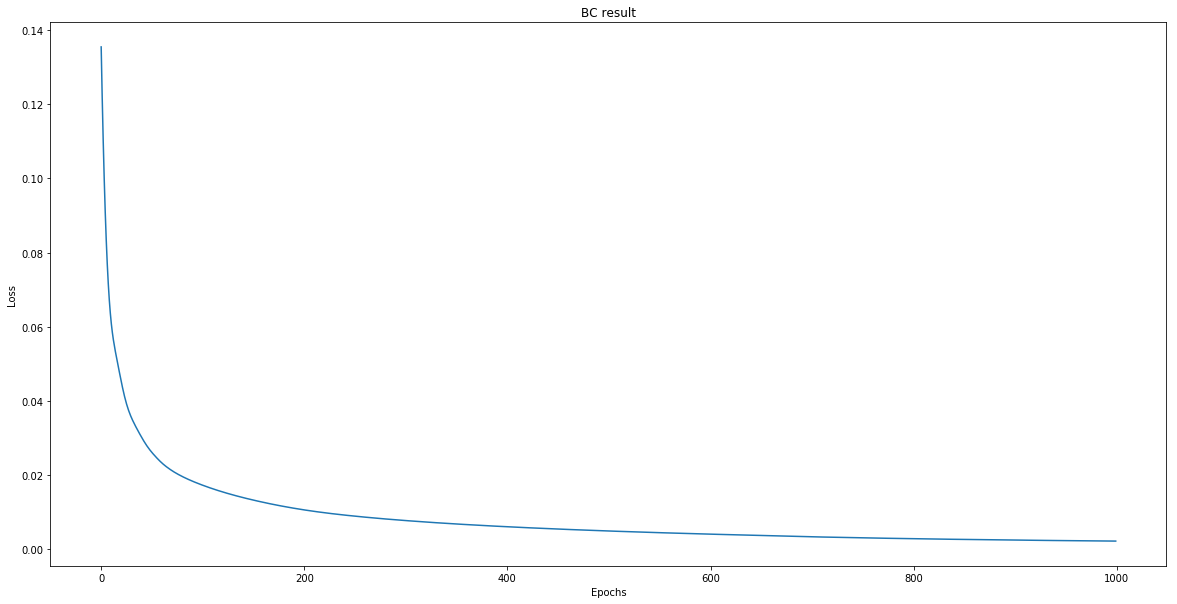

[2018-04-08 06:05:31,726] Making new env: Ant-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [4755.951405389098, 4809.865972765068, 4903.004428210498, 4703.825328243442, 4603.059773761673, 4623.199866532562, 4693.363608248662, 4664.688189447404, 4603.412741365919, 4693.128093718056]
mean return 4705.3499407682375
std of return 90.61084887239691
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=8)
)
Epoch: 0
Epoch: 150
Epoch: 300
Epoch: 450
Epoch: 600
Epoch: 750
Epoch: 900
Epoch: 1050
Epoch: 1200
Epoch: 1350
Behaviour cloning finished


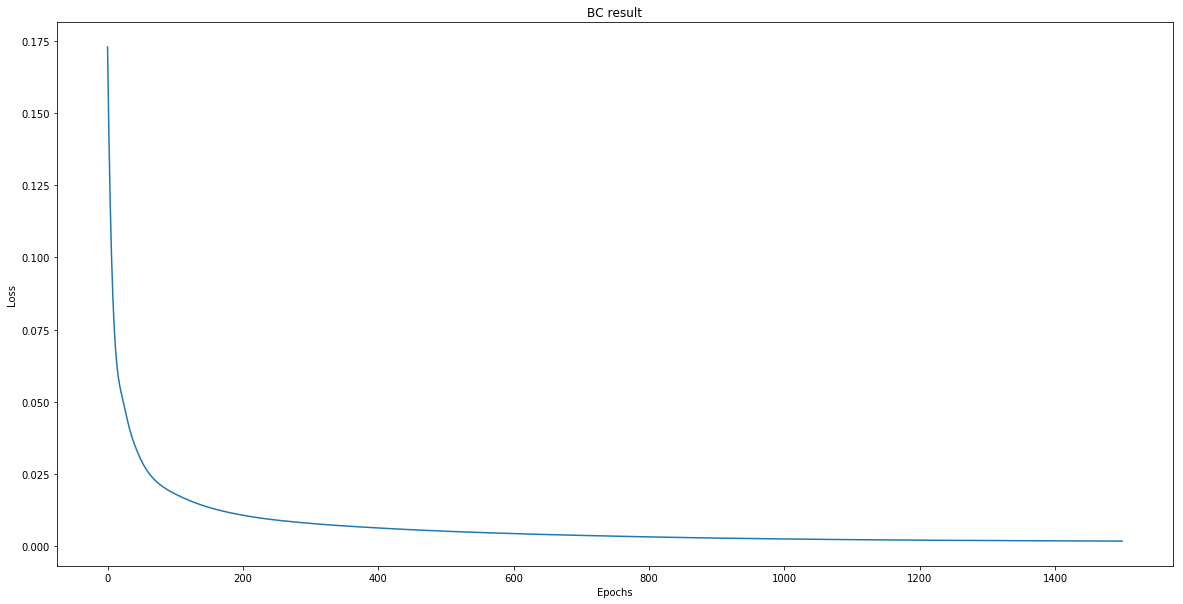

[2018-04-08 06:05:50,289] Making new env: Ant-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
returns [4712.007078925174, 4715.008409320875, 4925.640900440107, 4768.414309016062, 4755.9957287277475, 4891.131493576524, 4701.034859085325, 4566.926593834935, 4784.330933006844, 4697.727784399003]
mean return 4751.821809033259
std of return 96.74812559900818


In [66]:
mean_rewards = []
test_values = [10, 50, 100, 250, 500, 750, 1000, 1500]
for num_epochs in test_values:
    ant_policy_network = BCAgent(ant_expert_data, num_epochs=num_epochs)
    ant_policy_fn = policy_wrapper(ant_policy_network)
    ant_agent_data, ant_returns = TestAgent(ant_policy_fn, env_name='Ant', render=False, num_rollouts=10)
    mean_rewards.append(np.mean(ant_returns))

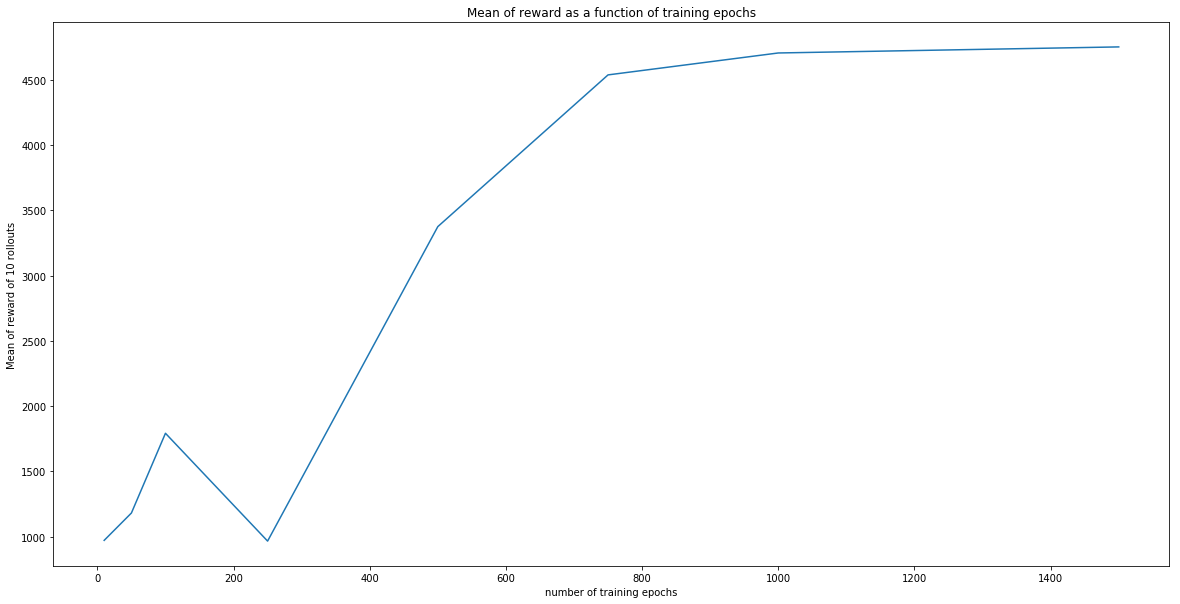

In [69]:
plt.plot(test_values, mean_rewards)
plt.title('Mean of reward as a function of training epochs')
plt.xlabel('number of training epochs')
plt.ylabel('Mean of reward of 10 rollouts')
plt.show()

In the very first implementations none of the trained agents could achieve any decent performance, mainly because of the lack of enough training time. Therefore it seemed interesting to me to depict the curve of the performance wrt. the # of epochs

Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=2)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


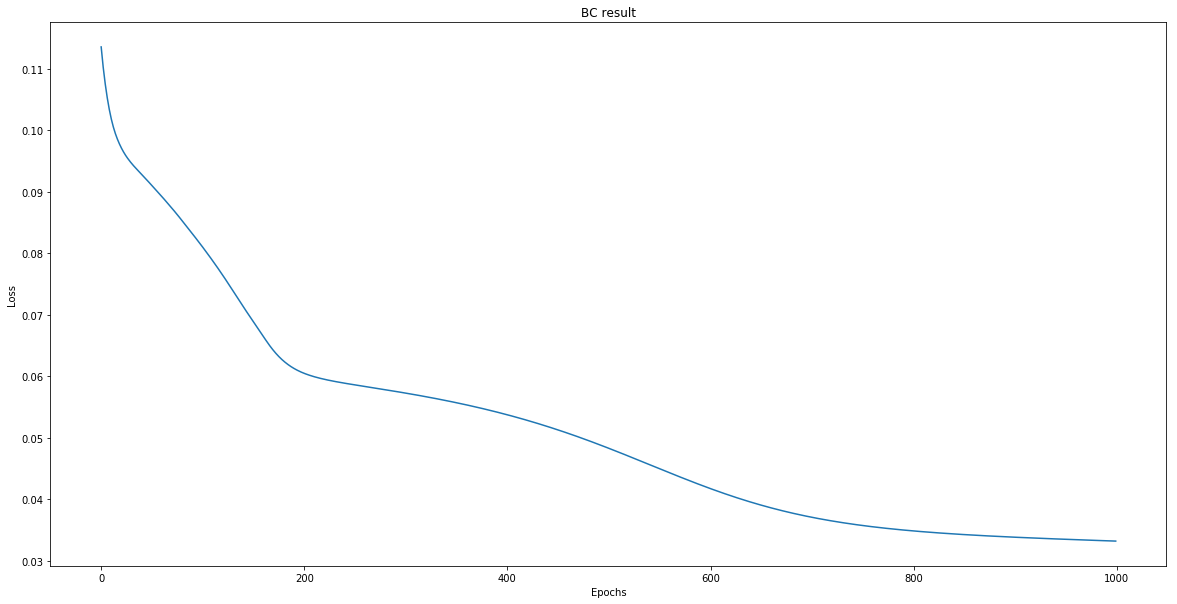

[2018-04-08 06:22:10,645] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [521.7045458997928, 493.90196484800236, 661.1407693744364]
mean return 558.9157600407439
std of return 73.16971266965813
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=3)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


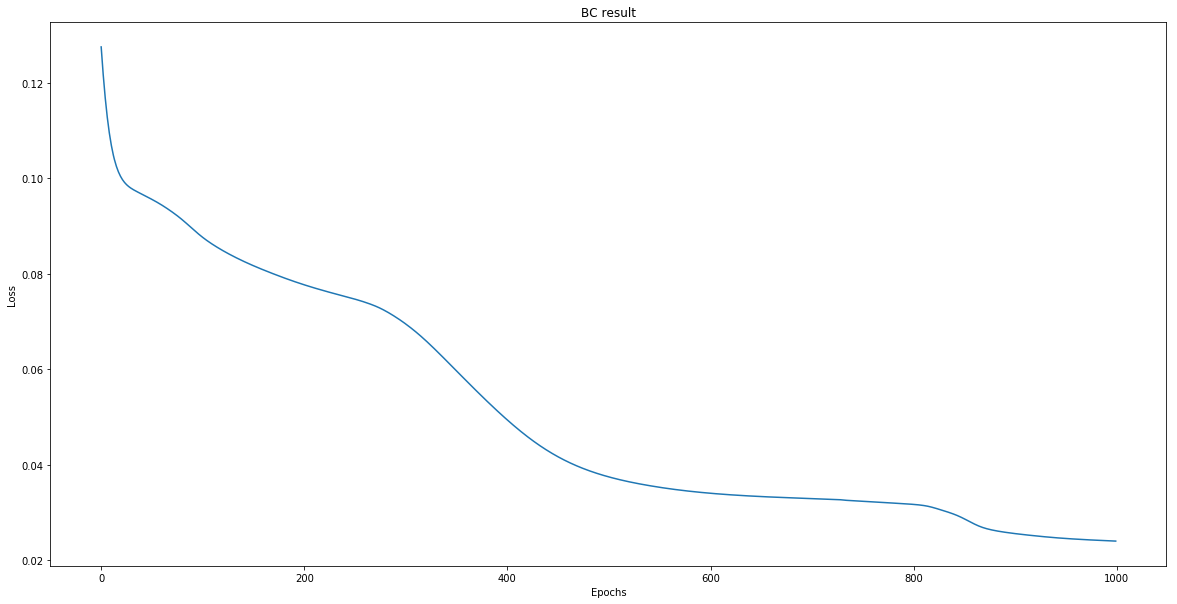

[2018-04-08 06:22:17,106] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [963.1012205401128, 857.4549386815065, 940.5801636729127]
mean return 920.3787742981773
std of return 45.43388102242108
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=4)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


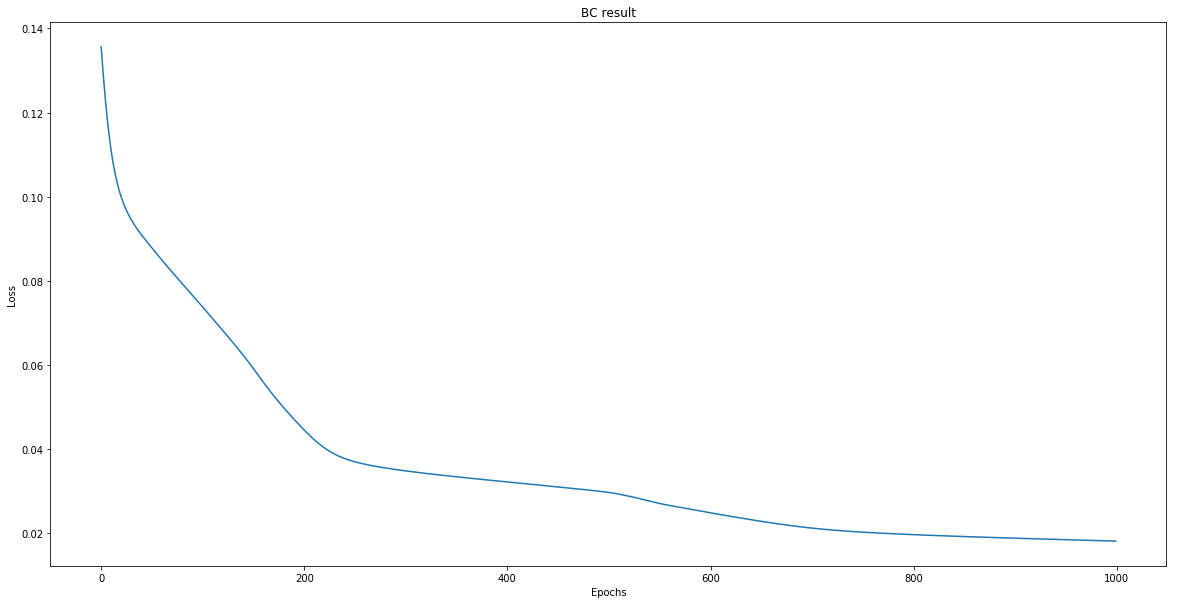

[2018-04-08 06:22:25,242] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [992.0279059457167, 217.3740512358453, 1369.4940432876158]
mean return 859.6320001563927
std of return 479.57733191055826
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=5)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


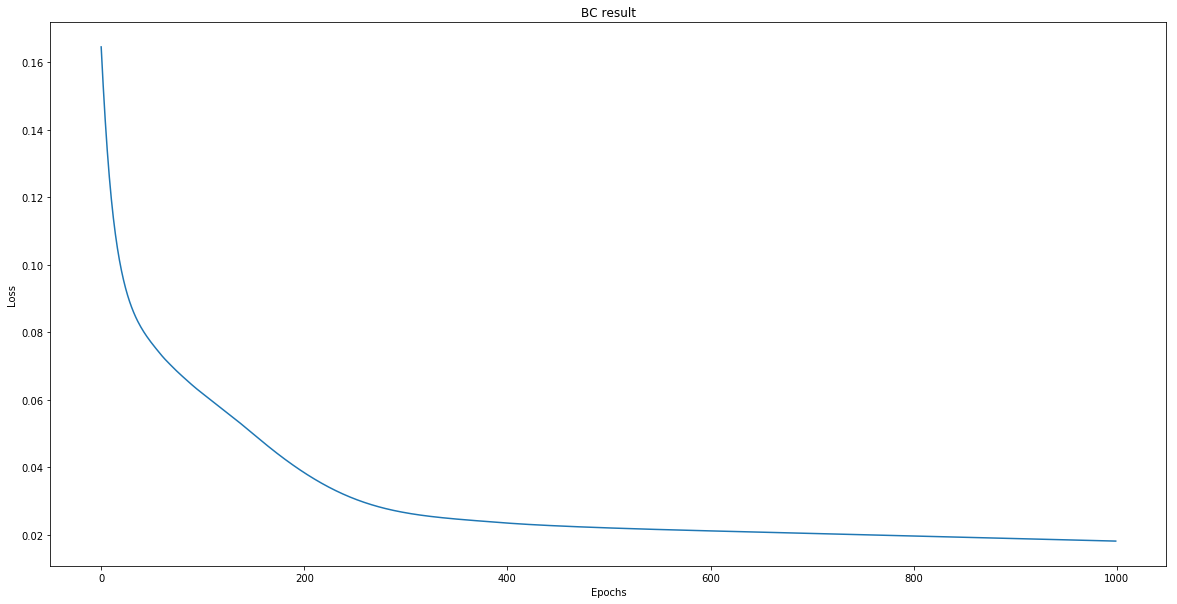

[2018-04-08 06:22:31,501] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [1305.0036760675218, 997.979576271117, 1040.674704523619]
mean return 1114.5526522874195
std of return 135.79252026109853
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=6)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


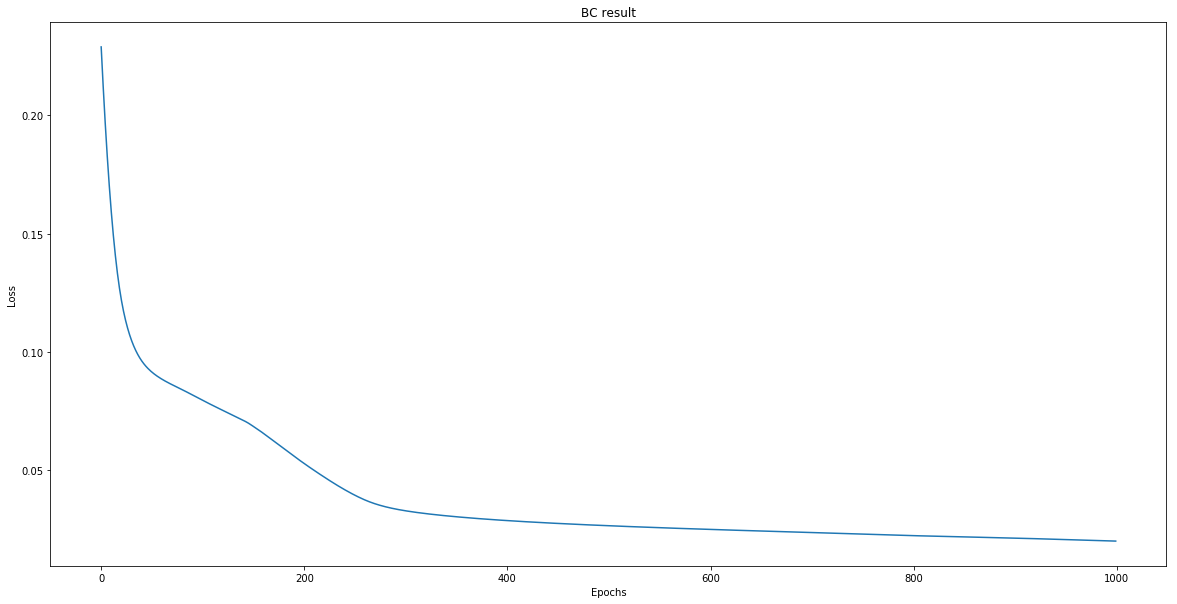

[2018-04-08 06:22:38,499] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [350.84302787282843, 224.4715515326086, 227.9680504993353]
mean return 267.7608766349241
std of return 58.765291723344006
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=7)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


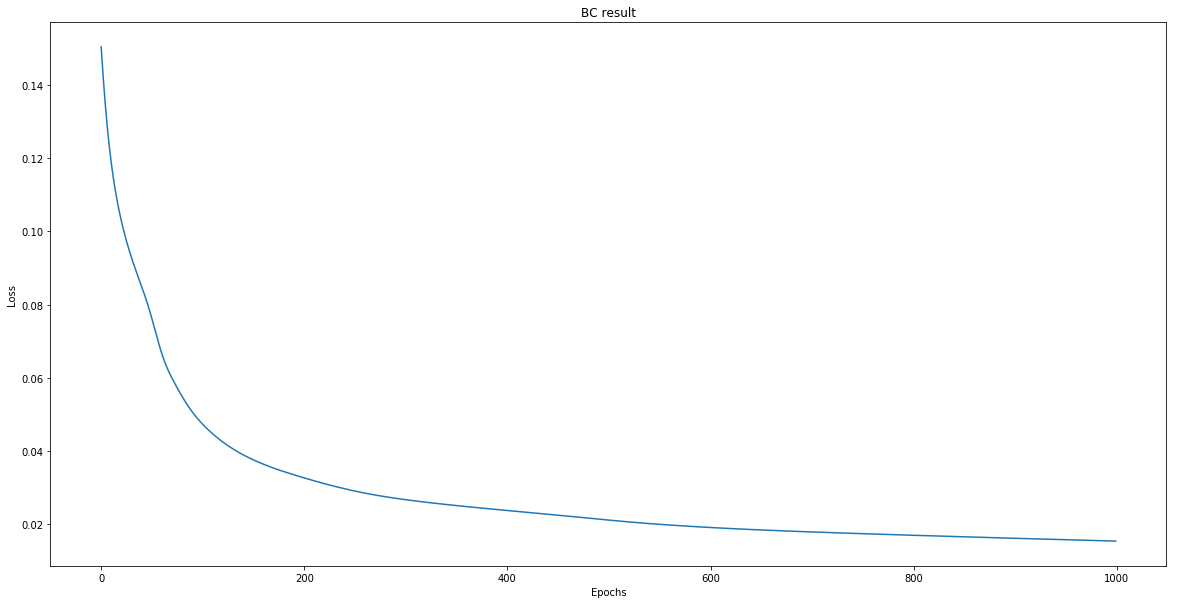

[2018-04-08 06:22:43,774] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [1010.6568077897097, 1109.417629654839, 369.36783643702074]
mean return 829.8140912938564
std of return 328.07162855351527
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=8)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


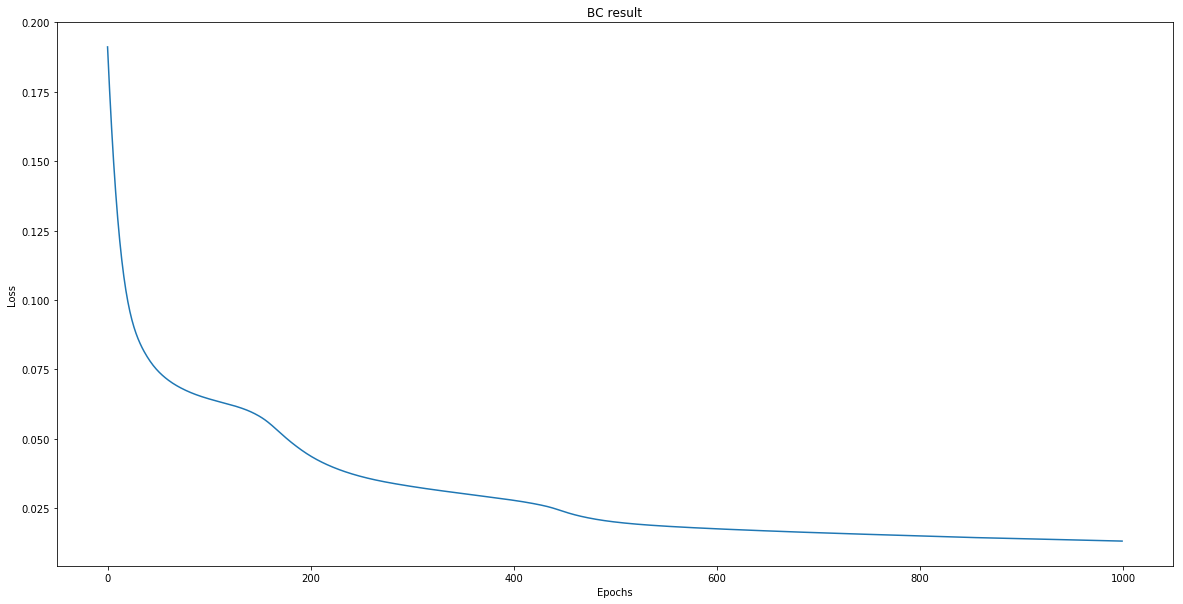

[2018-04-08 06:22:50,289] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [832.1642074045855, 2818.09014846822, 1601.9620354580447]
mean return 1750.7387971102835
std of return 817.5476966526849
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=9)
  (1): ReLU()
  (2): Linear(in_features=9, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


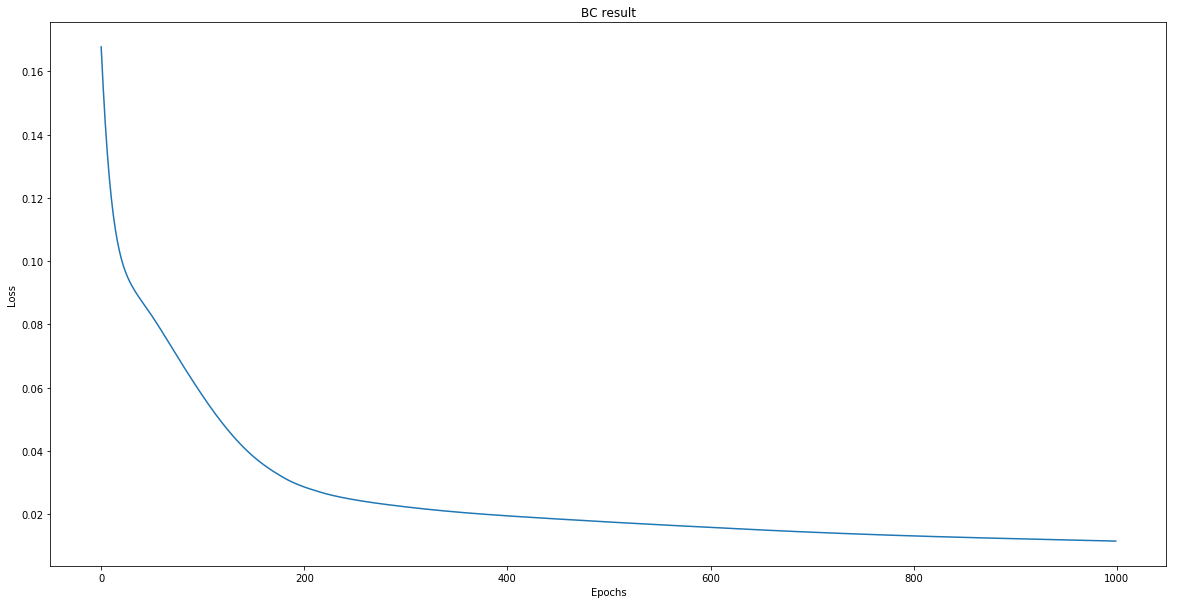

[2018-04-08 06:22:55,019] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [2398.9045111887435, 448.6651348137172, 2156.3756752217973]
mean return 1667.9817737414194
std of return 867.8536199703003
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=10)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


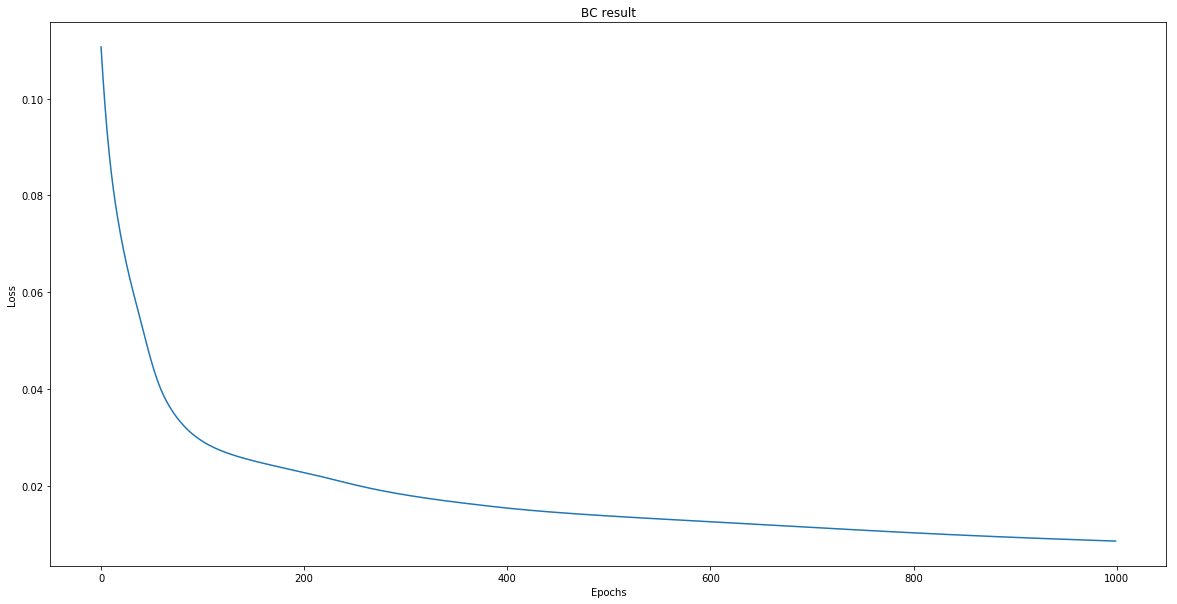

[2018-04-08 06:23:00,072] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [3411.7546902941663, 3872.7811693593517, 2771.423887579996]
mean return 3351.986582411171
std of return 451.609075471281
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=11)
  (1): ReLU()
  (2): Linear(in_features=11, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


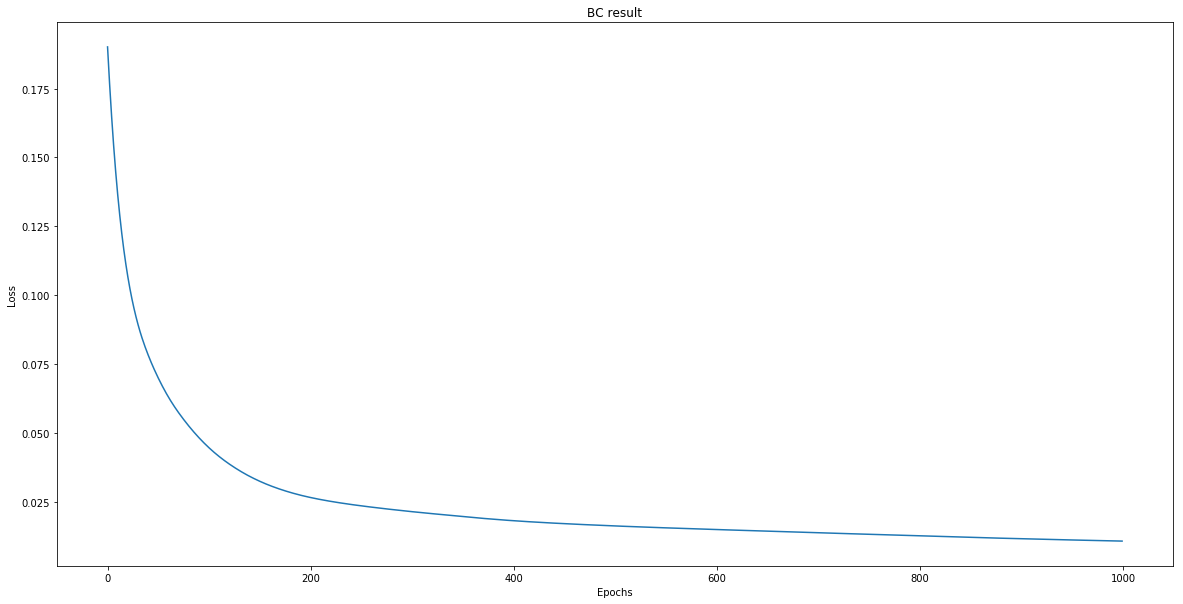

[2018-04-08 06:23:05,932] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [1651.6066721416869, 1644.2570539082571, 1638.5280908615928]
mean return 1644.7972723038456
std of return 5.352955508327847
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=12)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


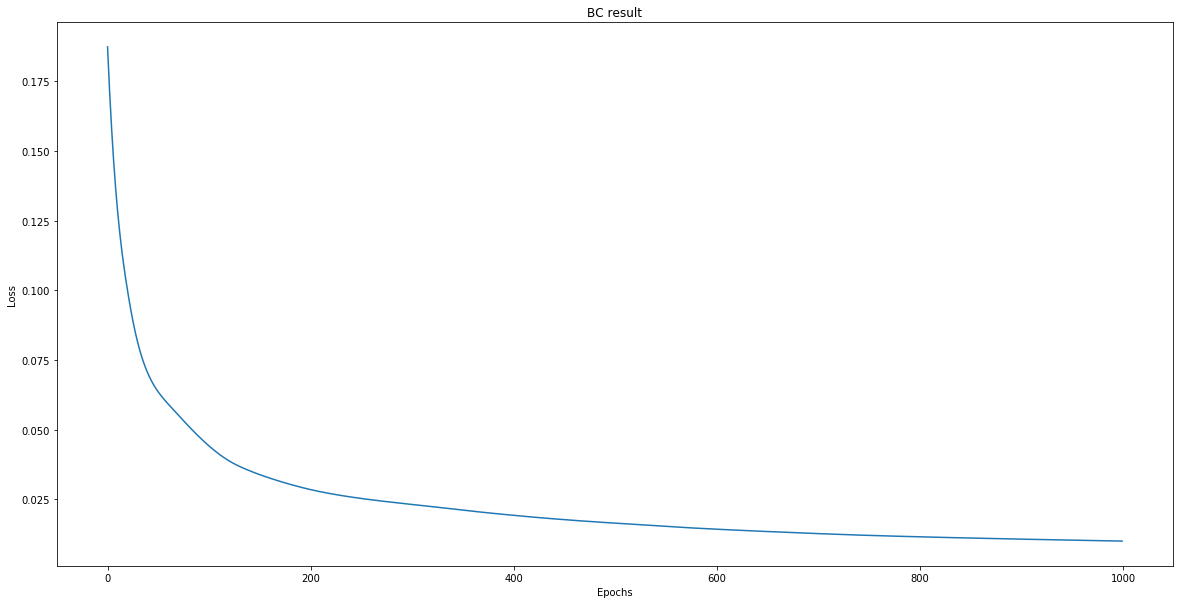

[2018-04-08 06:23:12,072] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [1009.2967212182134, 1211.4000891112264, 1824.402322922432]
mean return 1348.3663777506238
std of return 346.57284818648355
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=13)
  (1): ReLU()
  (2): Linear(in_features=13, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


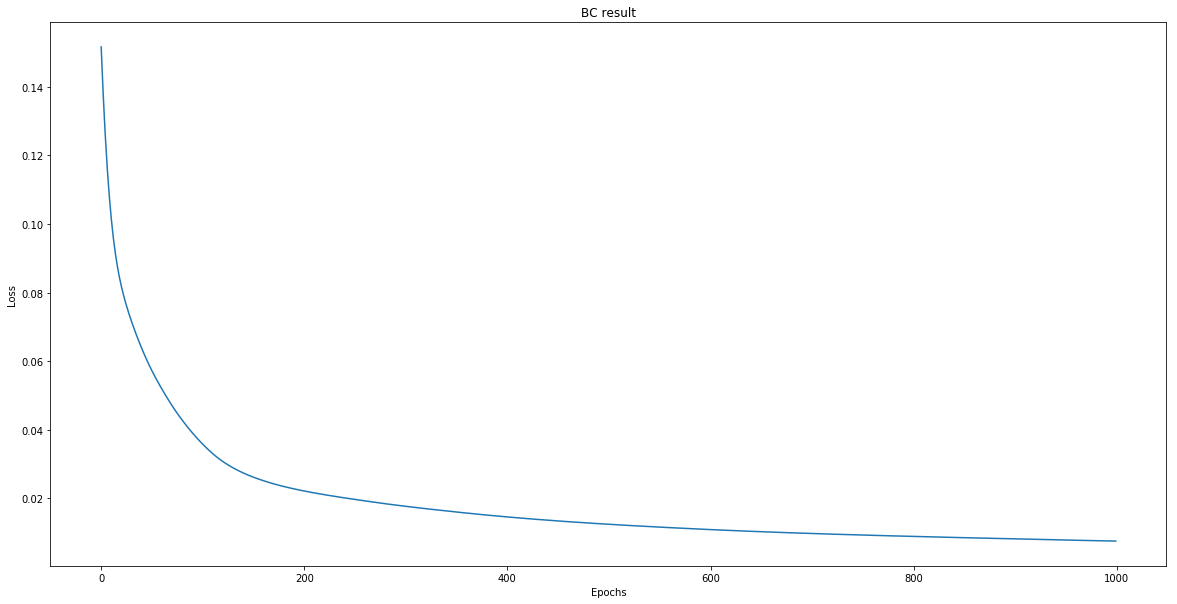

[2018-04-08 06:23:15,907] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [3869.424911101616, 3728.2181609303366, 2909.1194789465953]
mean return 3502.254183659516
std of return 423.3528237177167
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=14)
  (1): ReLU()
  (2): Linear(in_features=14, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


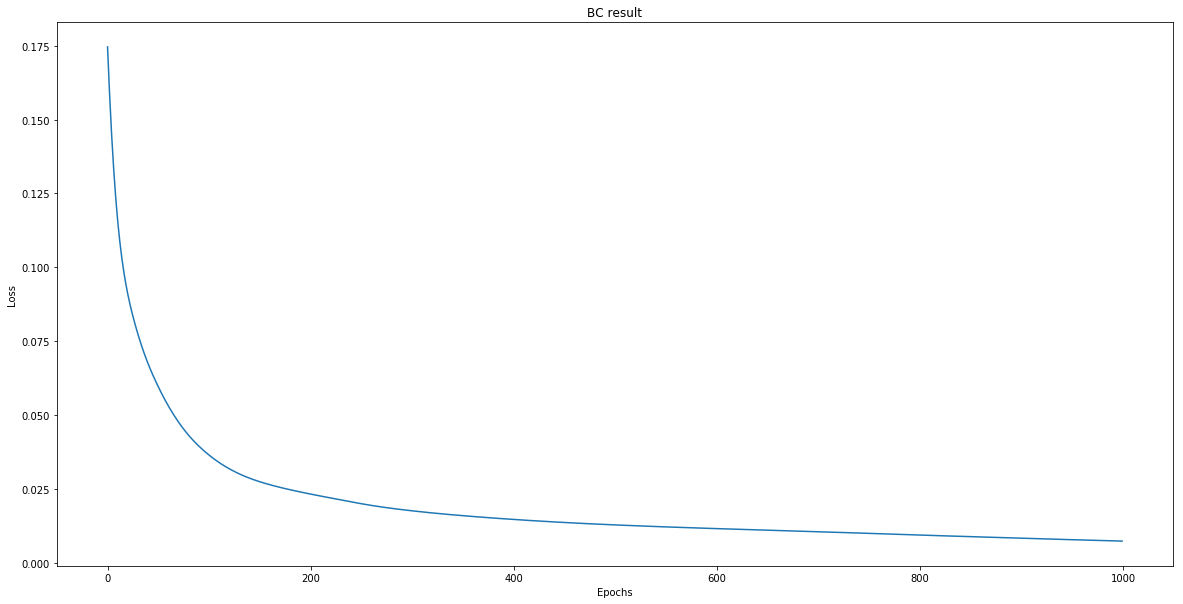

[2018-04-08 06:23:21,673] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [3738.0380630150357, 3750.325451453081, 1703.111138785764]
mean return 3063.82488441796
std of return 962.1829930399441
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=15)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


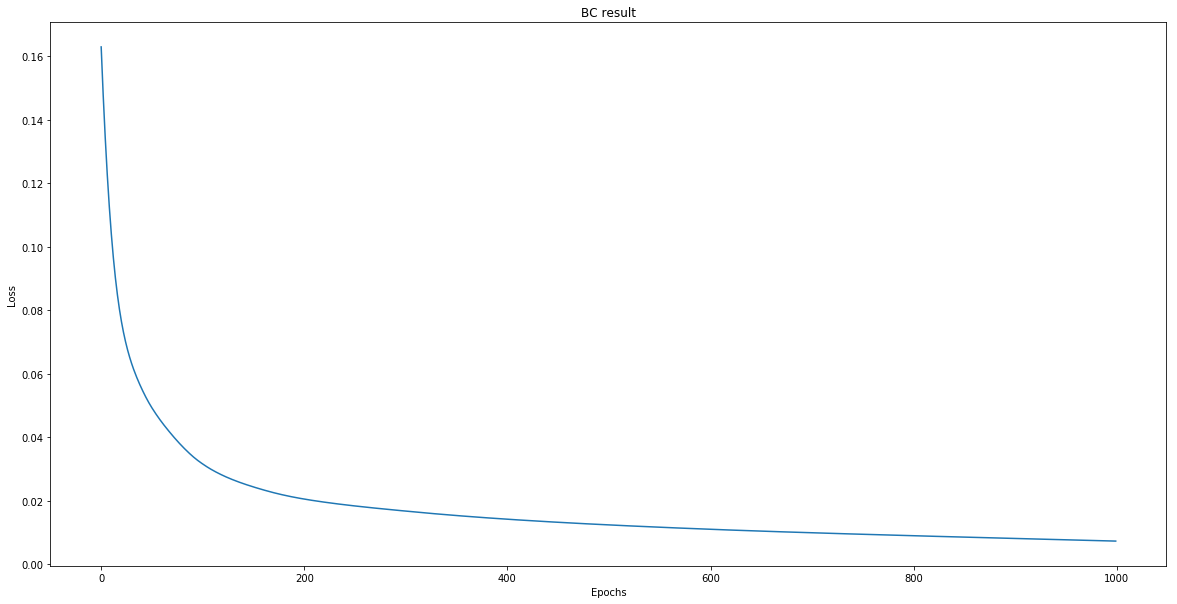

[2018-04-08 06:23:26,919] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [2547.6454579705155, 13.260691803074385, 542.8021828610281]
mean return 1034.5694442115393
std of return 1091.5288407389992
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=16)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


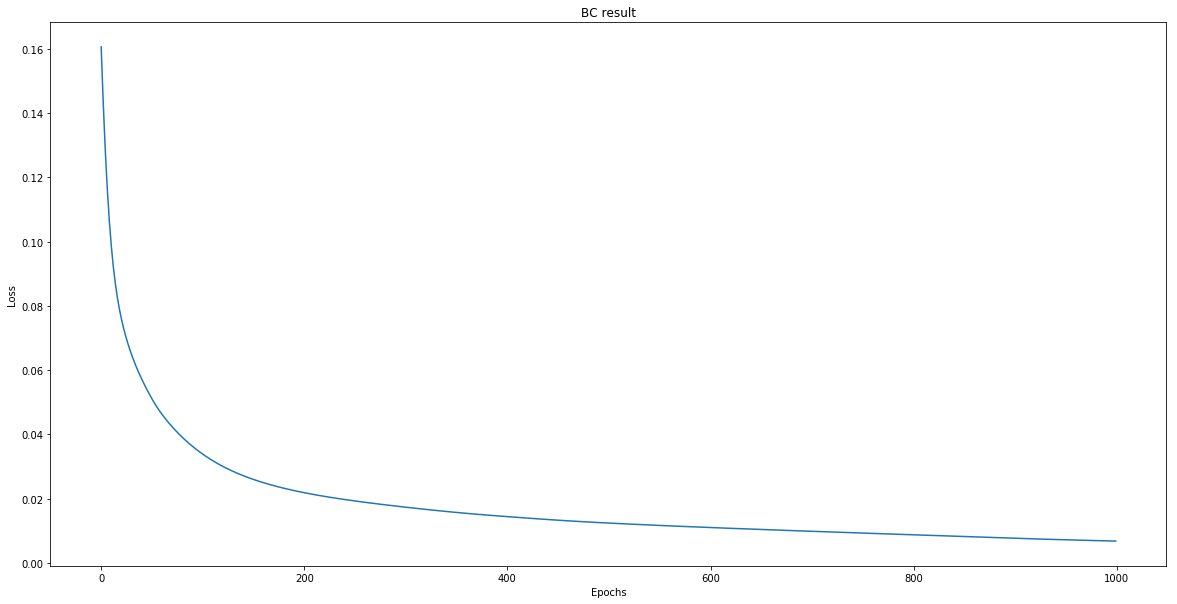

[2018-04-08 06:23:30,848] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [3504.1275933848806, 2391.776743077218, 4244.742736964826]
mean return 3380.215691142308
std of return 761.5275715139942
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=17)
  (1): ReLU()
  (2): Linear(in_features=17, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


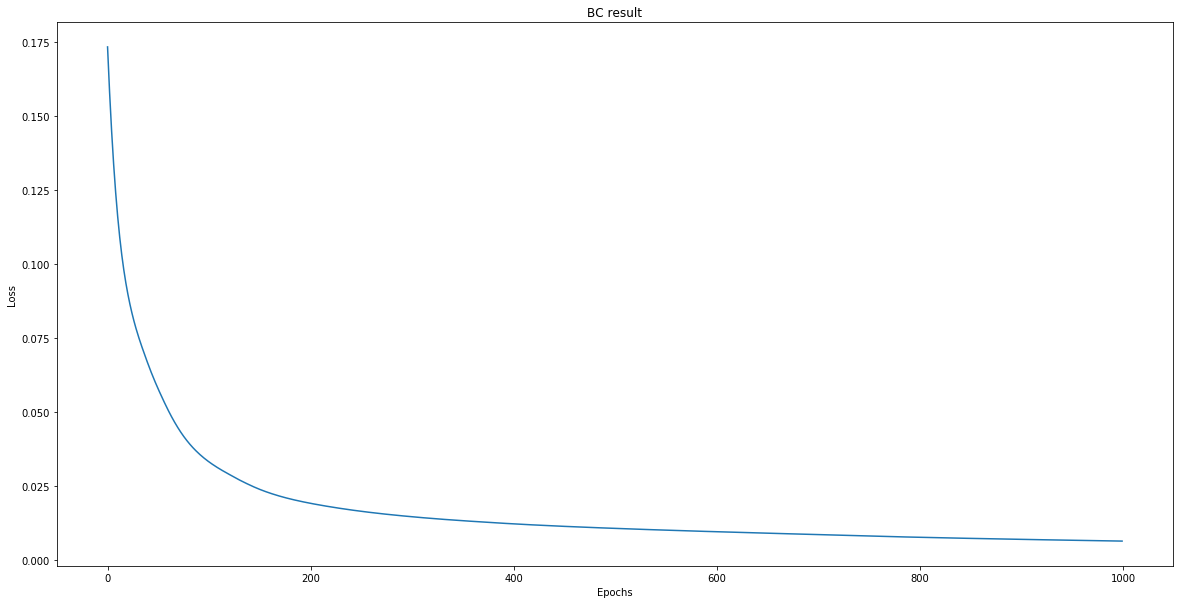

[2018-04-08 06:23:36,050] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [3728.9738158283535, 4101.514084071439, 4338.405588331163]
mean return 4056.297829410318
std of return 250.8454419201374
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=18)
  (1): ReLU()
  (2): Linear(in_features=18, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


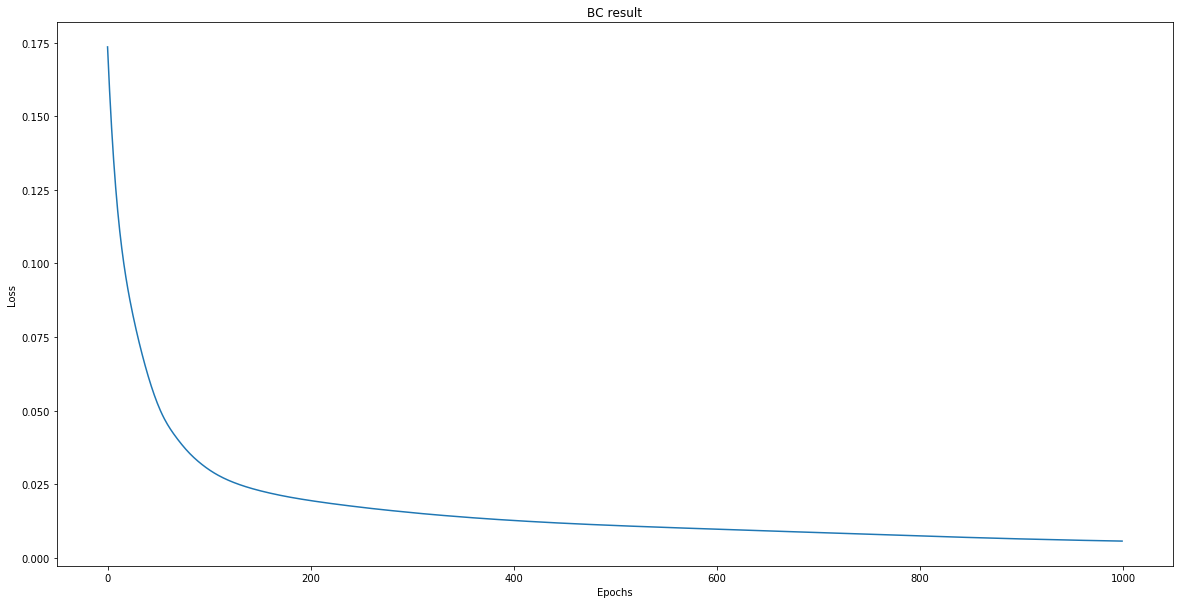

[2018-04-08 06:23:41,840] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [4034.0746646701537, 4474.145274109215, 4464.724514844079]
mean return 4324.314817874482
std of return 205.26681429355494
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=19)
  (1): ReLU()
  (2): Linear(in_features=19, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


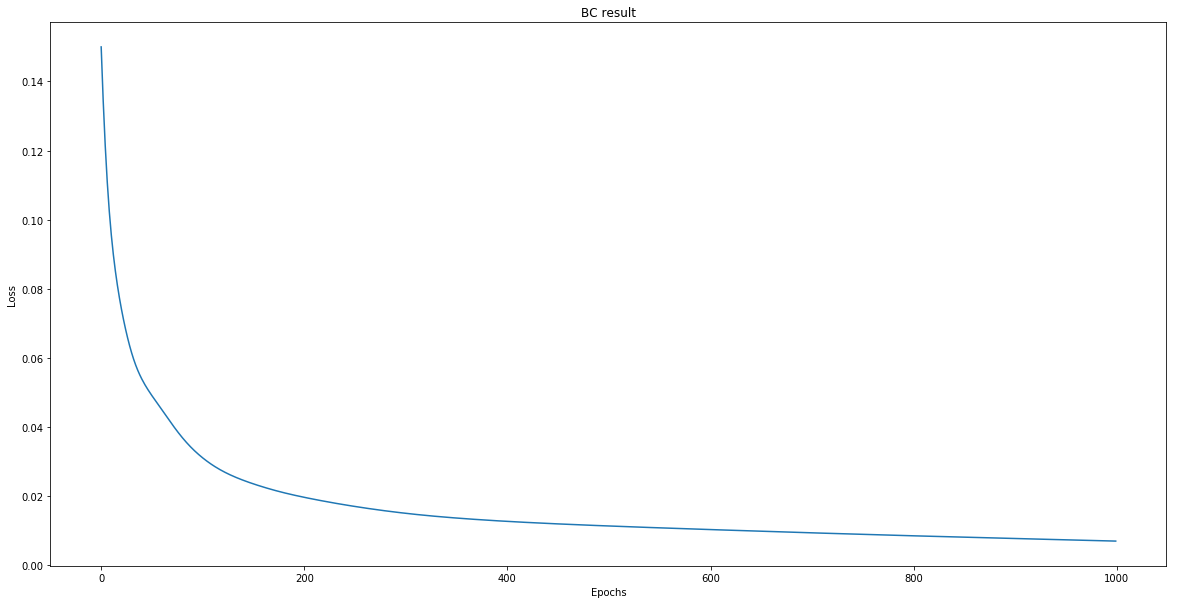

[2018-04-08 06:23:47,597] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [2531.80506977711, 619.8306625737803, 585.3698663719193]
mean return 1245.668532907603
std of return 909.5446773786441
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=20)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


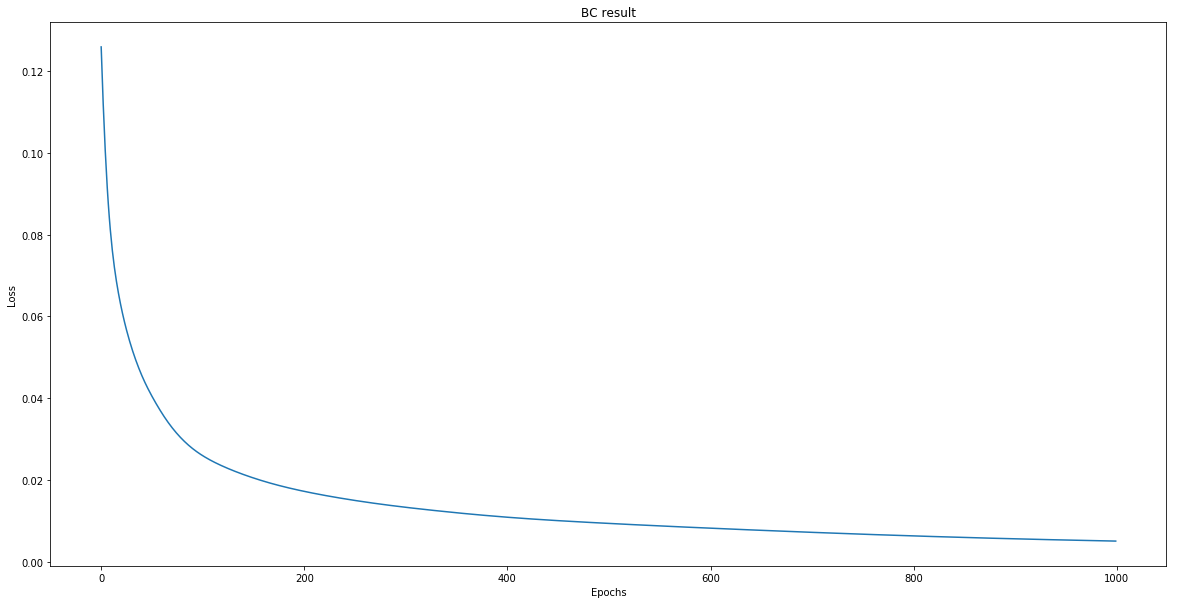

[2018-04-08 06:23:51,440] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [4304.696146743082, 4417.7219293020435, 4272.215428307684]
mean return 4331.544501450936
std of return 62.36270825204459
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=21)
  (1): ReLU()
  (2): Linear(in_features=21, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


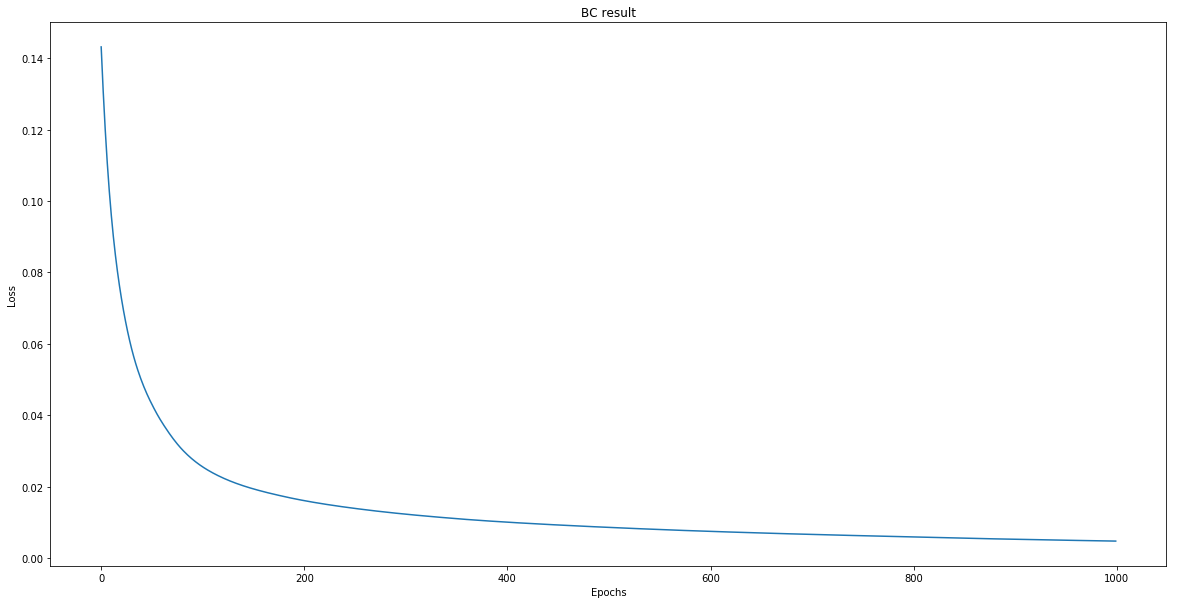

[2018-04-08 06:23:57,281] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [4506.795824128269, 4383.275662813983, 4500.699269584661]
mean return 4463.590252175637
std of return 56.84550373643856
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=22)
  (1): ReLU()
  (2): Linear(in_features=22, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


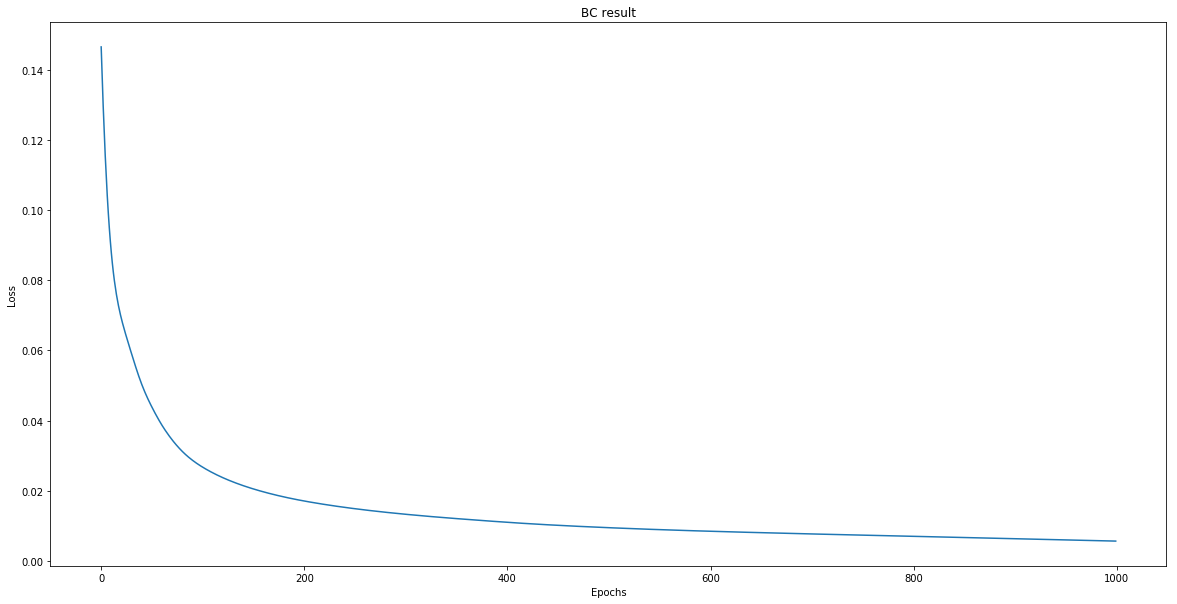

[2018-04-08 06:24:02,995] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [1323.0792118381382, 3860.0975138689305, 4337.366874060199]
mean return 3173.5145332557563
std of return 1322.8831315493665
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=23)
  (1): ReLU()
  (2): Linear(in_features=23, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


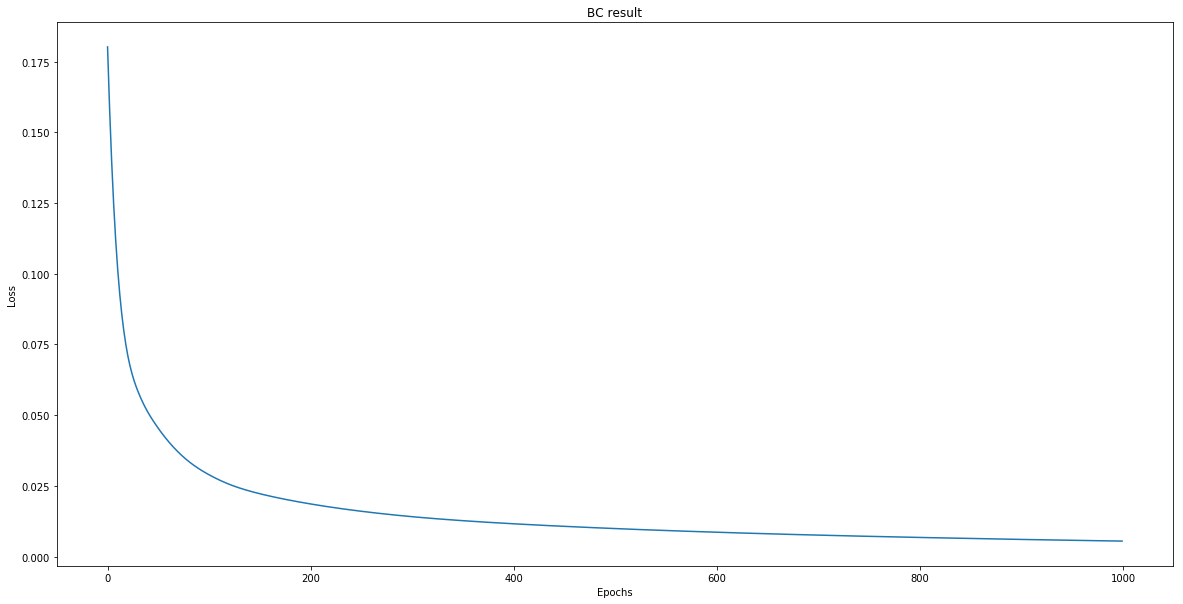

[2018-04-08 06:24:08,081] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [4316.958043681886, 4412.0665771667245, 4511.7447778202095]
mean return 4413.589799556273
std of return 79.52864517017122
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=24)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


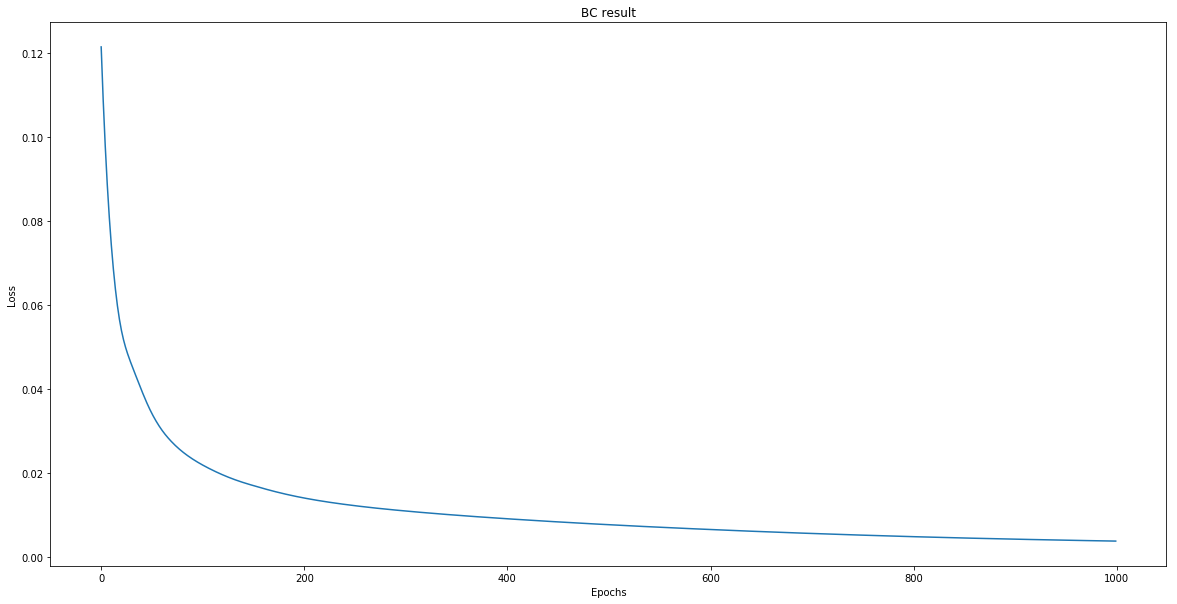

[2018-04-08 06:24:13,877] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [3527.005606208454, 4761.064590974304, 4063.367136553297]
mean return 4117.145777912018
std of return 505.2355893838852
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=25)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


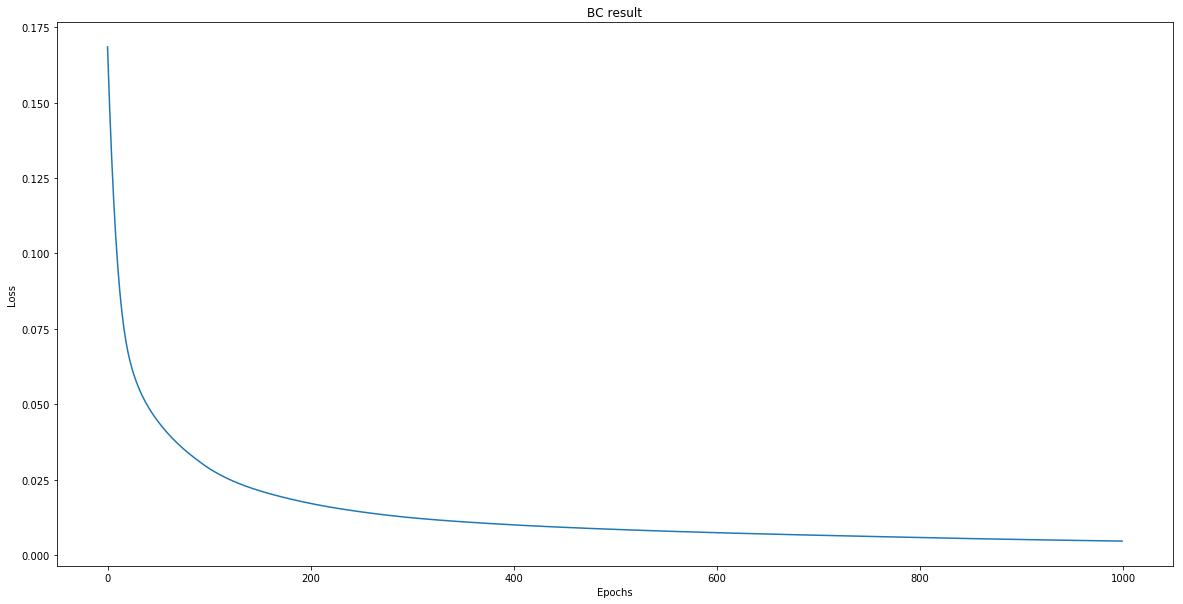

[2018-04-08 06:24:19,278] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [4157.15433457003, 4329.689337027968, 1691.3539801019772]
mean return 3392.732550566659
std of return 1205.116553642737
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=26)
  (1): ReLU()
  (2): Linear(in_features=26, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


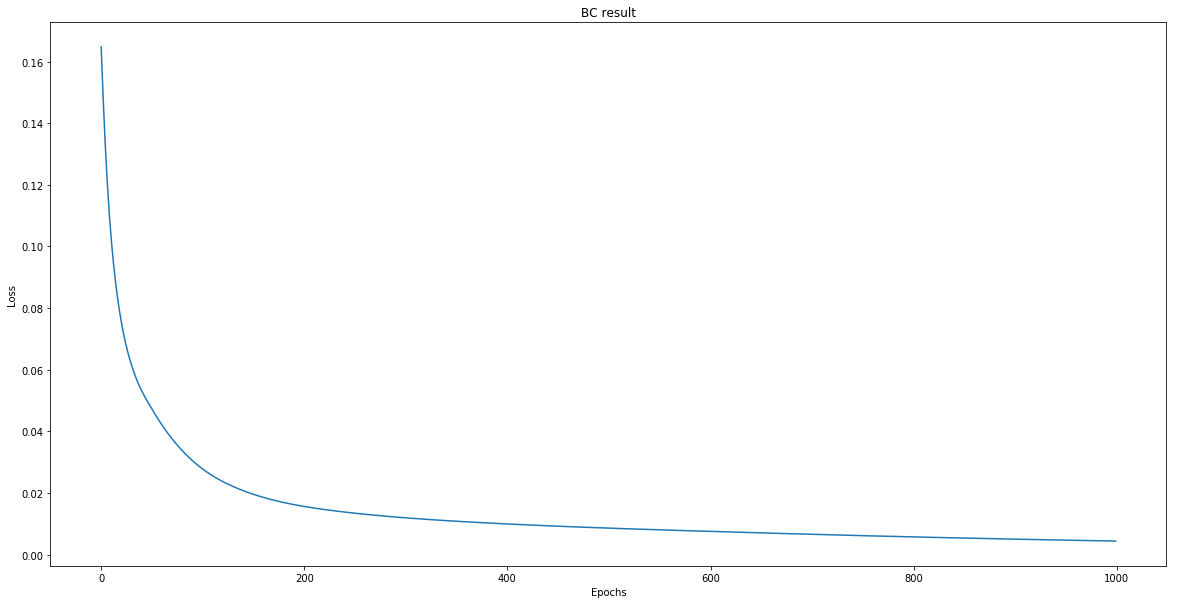

[2018-04-08 06:24:24,048] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [1042.7959689856575, 4277.7419892446915, 4570.652775111375]
mean return 3297.0635777805746
std of return 1598.4869973750647
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=27)
  (1): ReLU()
  (2): Linear(in_features=27, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


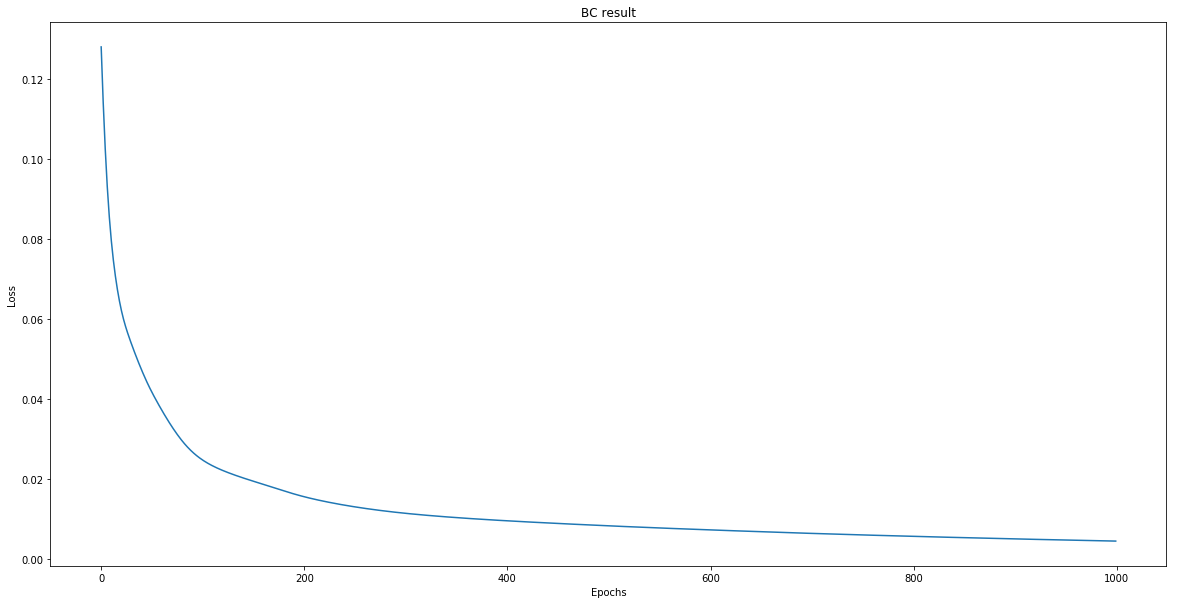

[2018-04-08 06:24:28,772] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [4400.804768306564, 1657.8532198867454, 4360.461893141056]
mean return 3473.0399604447884
std of return 1283.6365176631207
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=28)
  (1): ReLU()
  (2): Linear(in_features=28, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


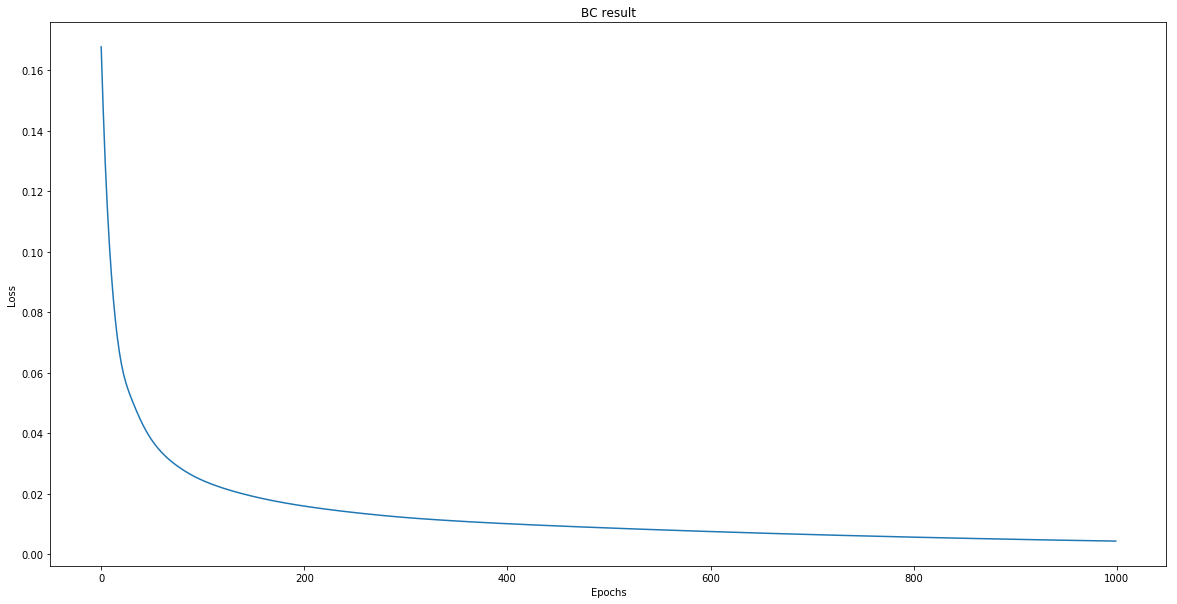

[2018-04-08 06:24:33,717] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [4433.342645193741, 4236.028700283205, 4095.5930376821098]
mean return 4254.988127719685
std of return 138.5359021098975
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=29)
  (1): ReLU()
  (2): Linear(in_features=29, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


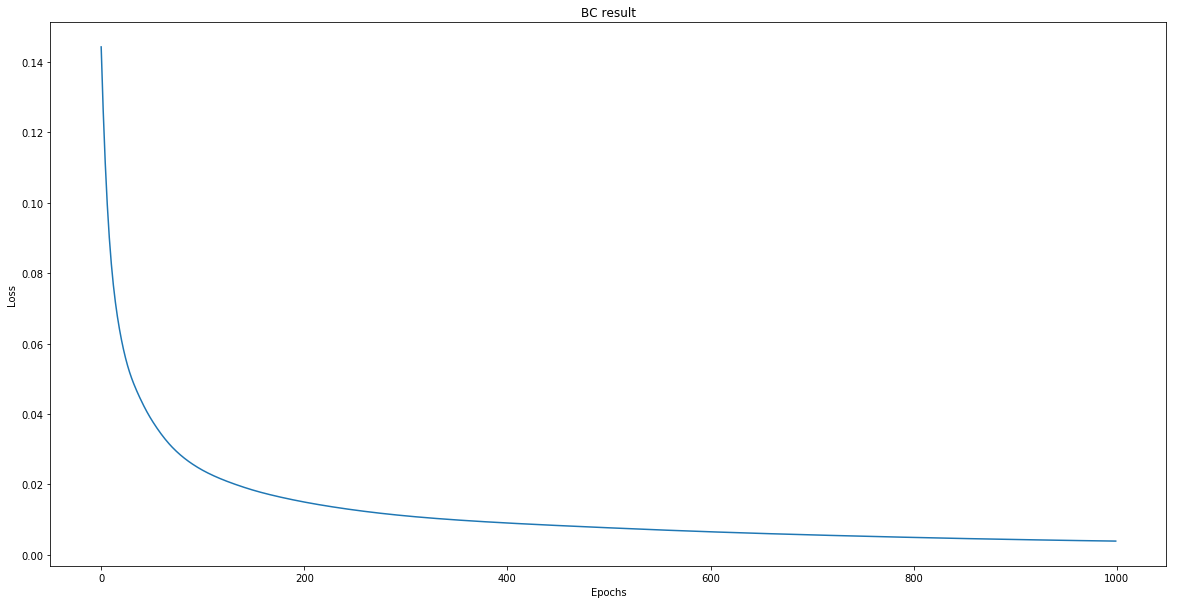

[2018-04-08 06:24:39,104] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [4608.6447075131055, 4674.8286904507695, 4529.037576612151]
mean return 4604.1703248586755
std of return 59.60300492245887
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=30)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


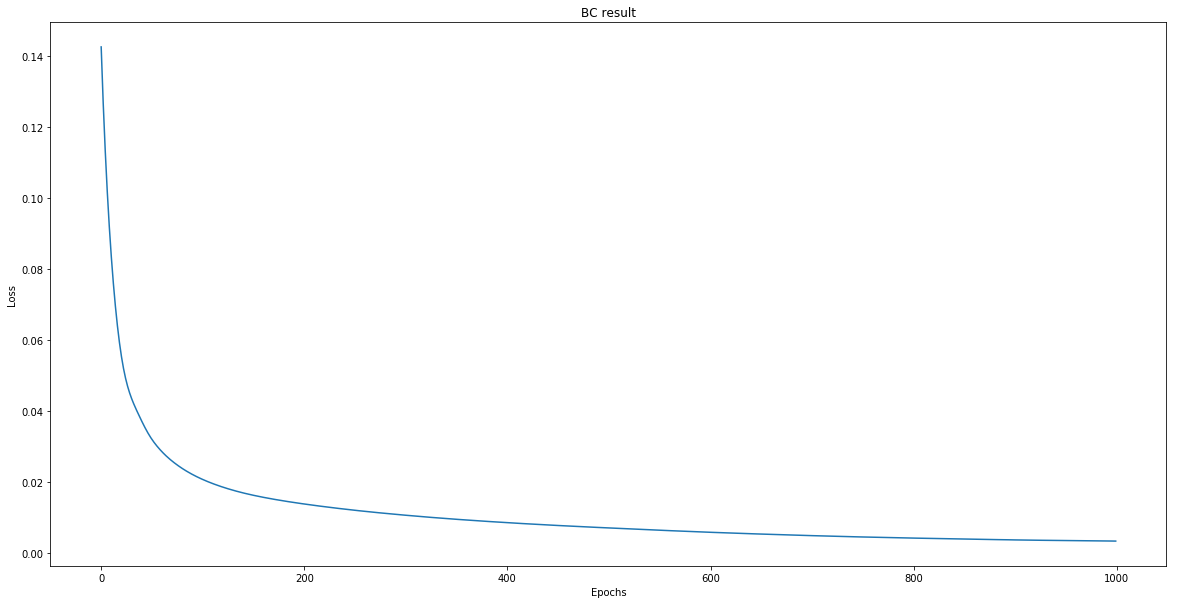

[2018-04-08 06:24:44,525] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [4602.23226826394, 4302.3607240696565, 4662.464055785249]
mean return 4522.352349372949
std of return 157.4890545608192
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=111, out_features=31)
  (1): ReLU()
  (2): Linear(in_features=31, out_features=8)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


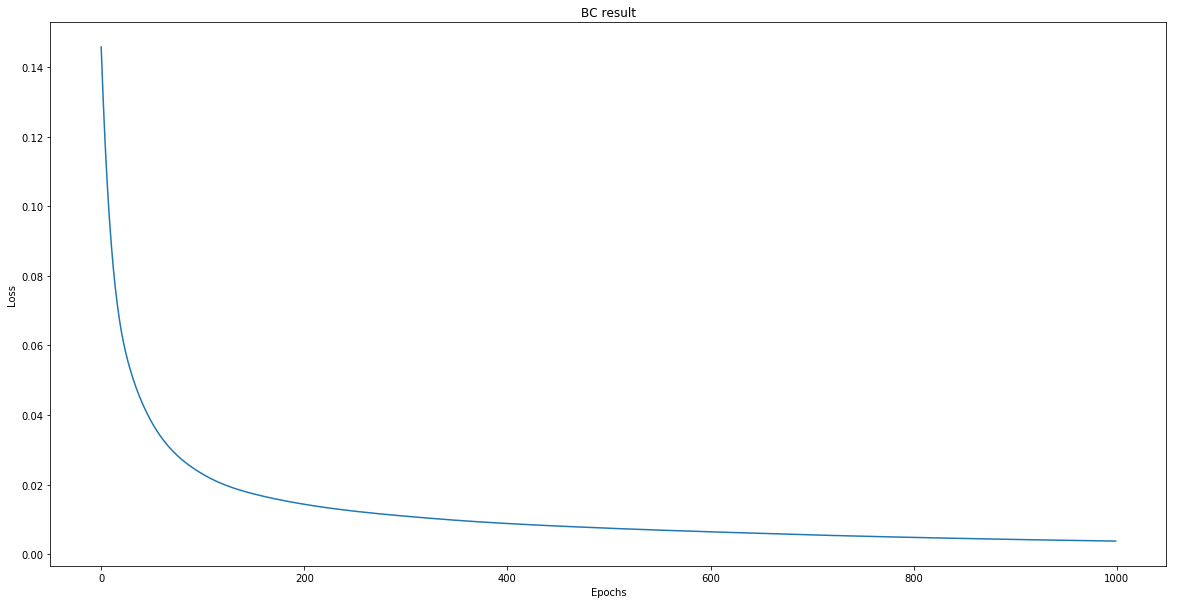

[2018-04-08 06:24:50,118] Making new env: Ant-v1


iter 0
iter 1
iter 2
returns [4679.146937813042, 4839.916733904306, 4445.473734385994]
mean return 4654.845802034447
std of return 161.94490599655182


In [83]:
hidden_mean_rewards = []
test_values = range(2, 32)
for hidden_dim in test_values:
    ant_policy_network = BCAgent(ant_expert_data, hidden_dims=[hidden_dim], num_epochs=1000)
    ant_policy_fn = policy_wrapper(ant_policy_network)
    ant_agent_data, ant_returns = TestAgent(ant_policy_fn, env_name='Ant', render=False, 
                                            num_rollouts=3)
    hidden_mean_rewards.append(np.mean(ant_returns))

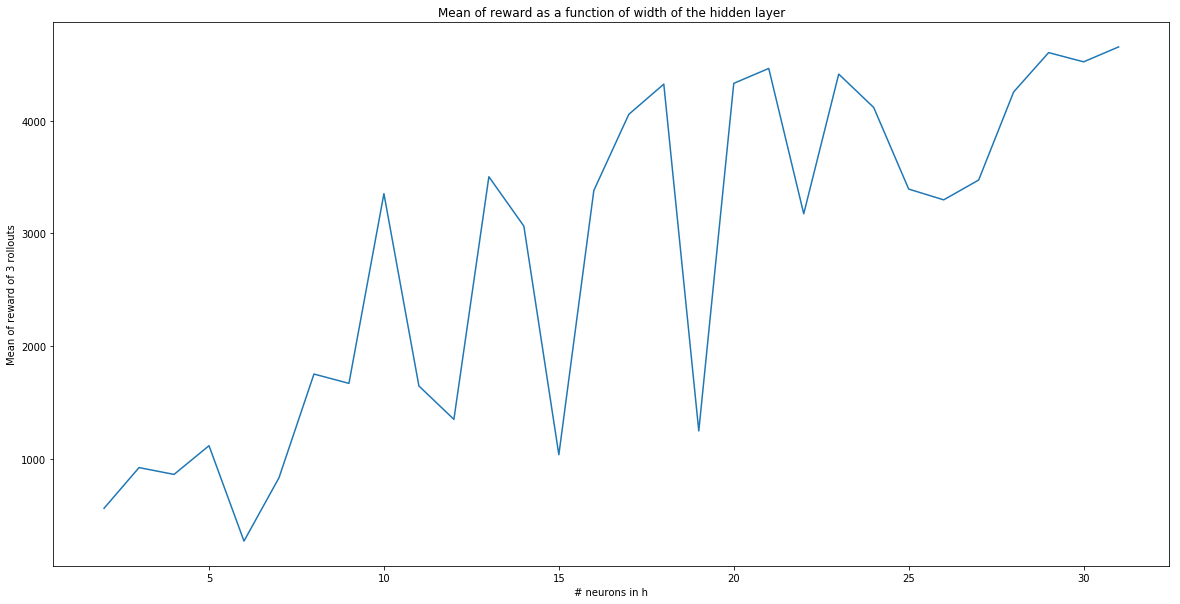

In [84]:
plt.plot(test_values, hidden_mean_rewards)
plt.title('Mean of reward as a function of width of the hidden layer')
plt.xlabel('# neurons in h')
plt.ylabel('Mean of reward of 3 rollouts')
plt.show()

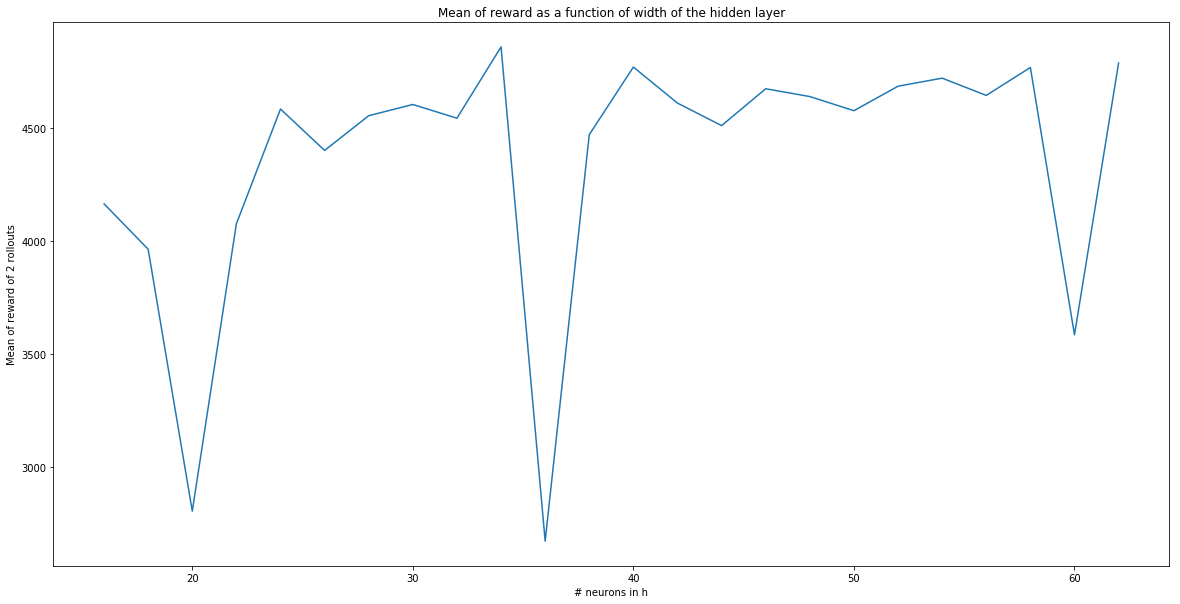

In [82]:
plt.plot(test_values, hidden_mean_rewards)
plt.title('Mean of reward as a function of width of the hidden layer')
plt.xlabel('# neurons in h')
plt.ylabel('Mean of reward of 2 rollouts')
plt.show()

It may be an expensive but quite describing metric if we take the performance as the function of the capacity of the underlying neural network.

As it was pointed out in [Deep Reinforcement Learning that Matters](https://arxiv.org/pdf/1709.06560.pdf): often there is no consistency in the type of network architectures and activation functions that are used in related literature. As shown in the paper and from our experimental results in later sections, we find, however, that these hyperparameters can have a significant effect in the performance of algorithms across benchmark environments typically used.

Maybe I should also experiment with the depth of the policy network, but that would be an overkill for now.

## DAgger

- Implement Domain Aggregation (DAgger). See the code provided in `run_expert.py` to see how to query the expert policy and perform roll-outs in the environment.

In [31]:
def SolveWithExpert(agent_data, env_name='Humanoid'):
    print('loading and building expert policy')
    policy_fn = load_policy.load_policy('experts/%s-v1.pkl'%env_name)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()
        # WWJD
        expert_action = policy_fn(agent_data['observations'])
    
    
    expert_data = {'observations': agent_data['observations'],
                   'actions': expert_action}
    
    return expert_data
    

In [32]:
# Storing the original experiments
orig_expert_data = hum_expert_data.copy()
orig_agent_data = hum_agent_data.copy()
env_name = 'Humanoid'

In [33]:
orig_expert_data['observations'].shape, orig_expert_data['actions'].shape

((20000, 376), (20000, 17))

Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


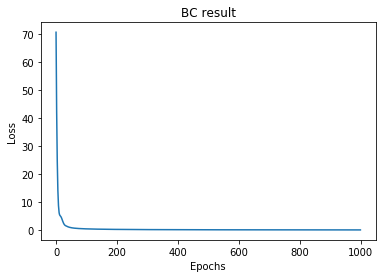

iter: 0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(1049, 376) (1049, 17)
(21049, 376)
(21049, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


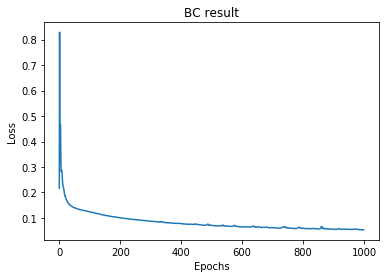

[2018-04-08 07:46:32,393] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1224.9077406069594, 708.371825147735, 651.3330096079706]
mean return 861.5375251208883
std of return 257.99456292247726
iter: 1
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(377, 376) (377, 17)
(21426, 376)
(21426, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


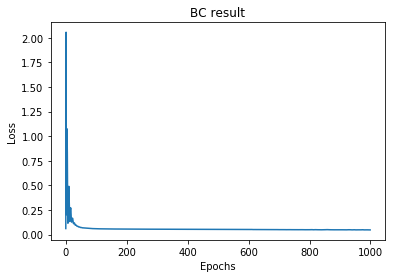

[2018-04-08 07:46:39,525] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [698.2857217897794, 821.235312979211, 4255.892245122383]
mean return 1925.1377599637915
std of return 1648.8564730460082
iter: 2
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(684, 376) (684, 17)
(22110, 376)
(22110, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


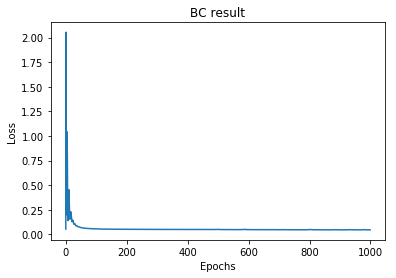

[2018-04-08 07:46:48,200] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [4309.20427237885, 4639.094375904237, 3377.698420696932]
mean return 4108.665689660006
std of return 534.1296542491651
iter: 3
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(1315, 376) (1315, 17)
(23425, 376)
(23425, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


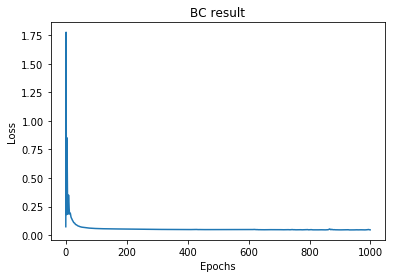

[2018-04-08 07:46:59,318] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10259.578826973615, 1210.6715786795562, 1047.1968437233356]
mean return 4172.482416458835
std of return 4304.744516648167
iter: 4
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(1308, 376) (1308, 17)
(24733, 376)
(24733, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


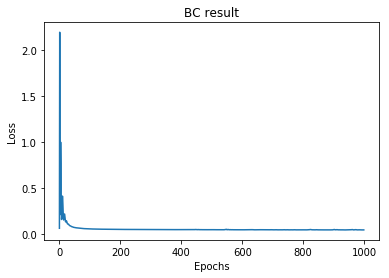

[2018-04-08 07:47:22,647] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [4353.390795271199, 2031.9672128033849, 2422.960950154357]
mean return 2936.1063194096464
std of return 1014.8039185972614
iter: 5
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(971, 376) (971, 17)
(25704, 376)
(25704, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


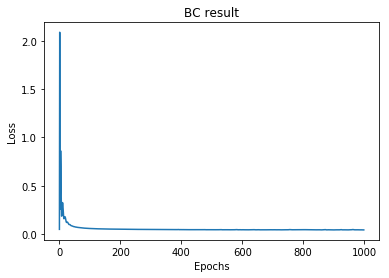

[2018-04-08 07:47:33,262] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [7640.431266938565, 760.4330706750399, 7647.585594535825]
mean return 5349.483310716477
std of return 3244.94985840245
iter: 6
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(1616, 376) (1616, 17)
(27320, 376)
(27320, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


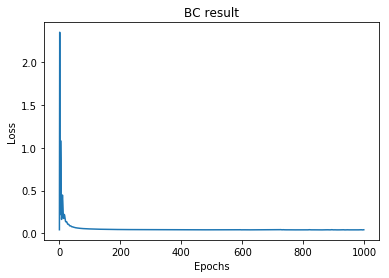

[2018-04-08 07:47:45,904] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10266.90937492734, 9119.162467563121, 3283.783813449642]
mean return 7556.618551980035
std of return 3057.4682628971636
iter: 7
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(2269, 376) (2269, 17)
(29589, 376)
(29589, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


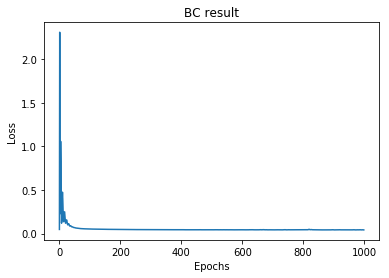

[2018-04-08 07:47:59,769] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10195.763940024959, 10328.943963363638, 10474.23932297217]
mean return 10332.982408786922
std of return 113.72295724838344
iter: 8
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(3000, 376) (3000, 17)
(32589, 376)
(32589, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


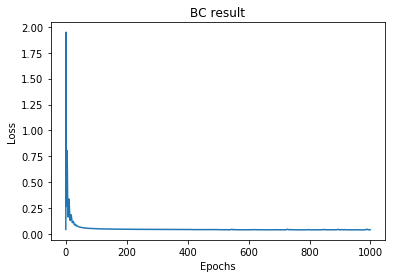

[2018-04-08 07:48:15,819] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10210.71330090292, 2019.2660080784876, 1528.8362573421682]
mean return 4586.271855441192
std of return 3982.117235439169
iter: 9
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(1443, 376) (1443, 17)
(34032, 376)
(34032, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


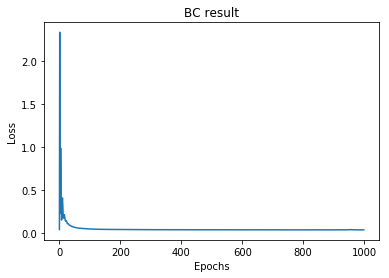

[2018-04-08 07:48:27,909] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10318.307090495427, 10352.695250092824, 545.7758555438759]
mean return 7072.25939871071
std of return 4614.942124288649
iter: 10
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(2089, 376) (2089, 17)
(36121, 376)
(36121, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


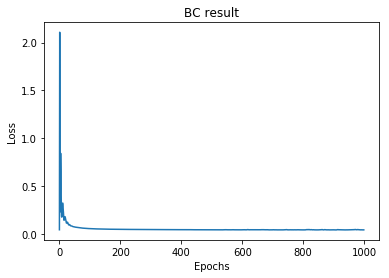

[2018-04-08 07:48:58,536] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10394.812779758582, 10301.156575978057, 10214.780436179159]
mean return 10303.583263971932
std of return 73.5179243207152
iter: 11
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(3000, 376) (3000, 17)
(39121, 376)
(39121, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


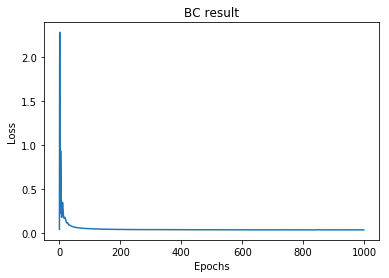

[2018-04-08 07:49:15,488] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10117.985666592218, 600.6492805532168, 10462.434633787034]
mean return 7060.356526977489
std of return 4569.866851078566
iter: 12
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(2091, 376) (2091, 17)
(41212, 376)
(41212, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


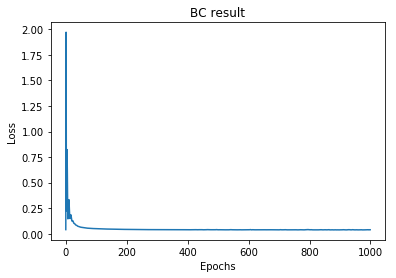

[2018-04-08 07:49:30,652] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10422.290649315373, 10373.158249774875, 10358.725550749505]
mean return 10384.72481661325
std of return 27.208693956676292
iter: 13
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(3000, 376) (3000, 17)
(44212, 376)
(44212, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


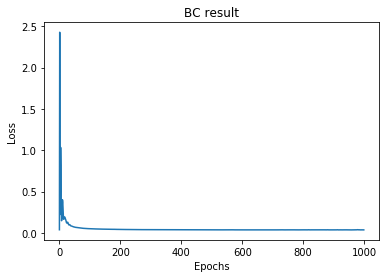

[2018-04-08 07:49:48,757] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10430.24818936931, 10465.817562798919, 10435.062336842791]
mean return 10443.709363003674
std of return 15.755916933308496
iter: 14
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(3000, 376) (3000, 17)
(47212, 376)
(47212, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


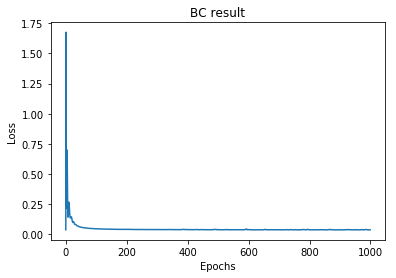

[2018-04-08 07:50:09,180] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10330.809408863795, 10400.143327165866, 10026.725331575843]
mean return 10252.559355868501
std of return 162.1779947114537
iter: 15
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(3000, 376) (3000, 17)
(50212, 376)
(50212, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


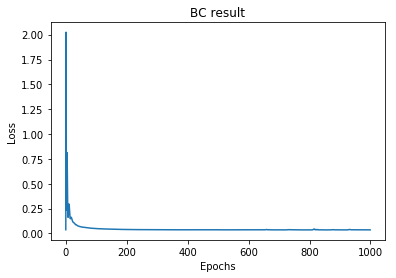

[2018-04-08 07:50:31,232] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10425.724844495608, 10358.628302558656, 10107.497540191582]
mean return 10297.283562415281
std of return 136.96602293657935
iter: 16
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(3000, 376) (3000, 17)
(53212, 376)
(53212, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


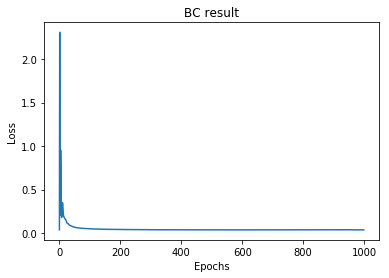

[2018-04-08 07:50:54,311] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10306.981962109674, 10386.76669871083, 10426.797205226867]
mean return 10373.515288682456
std of return 49.80376840904749
iter: 17
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(3000, 376) (3000, 17)
(56212, 376)
(56212, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


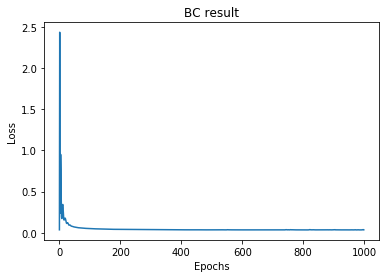

[2018-04-08 07:51:16,988] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10335.131613046677, 10387.471220800653, 10381.416561146976]
mean return 10368.006464998101
std of return 23.37707771873359
iter: 18
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(3000, 376) (3000, 17)
(59212, 376)
(59212, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


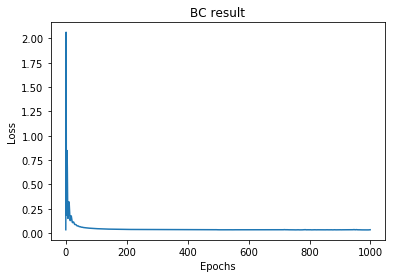

[2018-04-08 07:51:39,413] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10380.722523753095, 10340.362722466418, 10412.052628984438]
mean return 10377.712625067983
std of return 29.344565558340385
iter: 19
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
(3000, 376) (3000, 17)
(62212, 376)
(62212, 17)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


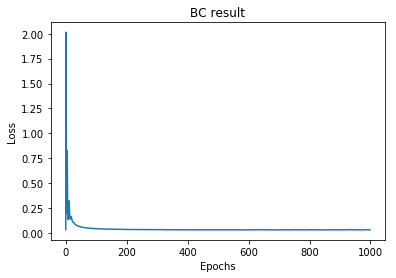

[2018-04-08 07:52:05,205] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10344.314615714402, 10445.796071390985, 10334.860177924516]
mean return 10374.9902883433
std of return 50.215806165173895


In [34]:
# Step 0
expert_data = orig_expert_data.copy()
agent_data = orig_agent_data.copy()
policy_network = BCAgent(expert_data)

num_dagger = 20
num_rollouts = 3

agent_rewards_mean = []
agent_rewards_std = []
expert_mean_rewards = np.ones(num_dagger) * 10415.85

for i in range(num_dagger):
    print('iter:', i)
    # Step i
    # EXTEND the training database with:
    # observations of the trained agent
    # actions of an expert agent
    new_expert_data = SolveWithExpert(agent_data, env_name=env_name)
    print(new_expert_data['observations'].shape, new_expert_data['actions'].shape)
    expert_data['observations'] = np.concatenate(
        (expert_data['observations'], new_expert_data['observations']))
    print(expert_data['observations'].shape)
    expert_data['actions'] = np.concatenate(
        (expert_data['actions'], new_expert_data['actions']))
    print(expert_data['actions'].shape)
    # Train an agent on the extended database
    policy_network = BCAgent(expert_data, pretrained_agent=policy_network)
    policy_fn = policy_wrapper(policy_network)
    agent_data, agent_returns = TestAgent(
        policy_fn, env_name=env_name, 
        render=True, num_rollouts=num_rollouts)
    
    agent_rewards_mean.append(np.mean(agent_returns))
    agent_rewards_std.append(np.std(agent_returns))

-  Run DAgger and report results on one task in which DAgger can learn a better policy than behavioral cloning.  Report your results in the form of a learning curve, plotting the number of DAgger iterations vs.  the policy’s mean return, with error bars to show the standard deviation.  Include the performance of the expert policy and the behavioral cloning agent on the same plot.  In the caption, state which task you used, and any details regarding network architecture, amount of data, etc.  (as in the previous section).

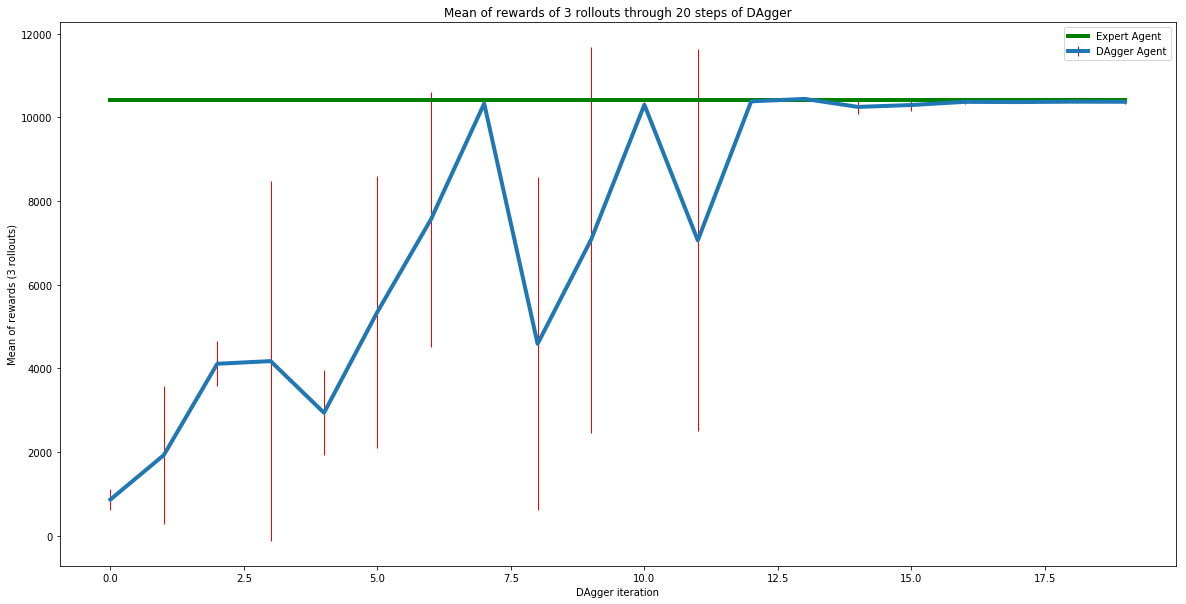

In [68]:
plt.errorbar(range(num_dagger), agent_rewards_mean, agent_rewards_std, 
             ecolor='r', linewidth=4, elinewidth=1, capthick=2, 
             label='DAgger Agent')
plt.plot(expert_mean_rewards, linewidth=4, color='green',
         label='Expert Agent')

plt.title('Mean of rewards of 3 rollouts through 20 steps of DAgger')
plt.xlabel('DAgger iteration')
plt.ylabel('Mean of rewards (3 rollouts)')
plt.legend()
plt.show()

I've used the Humanoid-v1 task, which was underperforming in vanilla BC.

Details:
- Network: 64 ReLU
- Optimizer: Adam (1000 epochs)
- Original expert training samples: 20k
- \# DAgger extension: 10
- \# rollouts with the fine-tuned agent: 3